# Darmstadt Urban Heat Typology Regression

Geoff & Avi - 10-26-24
we're trying to understand the affect of different types of 'built environment' on urban heat patterns
starting with data collected from Darmstadt

update - 13 Nov 2024

In [1]:
#import data libraries
import pandas as pd
import matplotlib.pyplot as plt

#import geographic analysis libraries
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely as shp
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
import seaborn as sns
import os
import re
from fiona.crs import from_epsg
import pysal as ps
#set crs for entire analysis
crs = {'init': 'epsg:4326'}
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100

In [2]:
#import machine learning / regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
### read in data
temp_df = pd.read_excel('../data/results/Darmstadt_typ_tmp_regression_data.xlsx')
temp_df

,Unnamed: 0,hex_id,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,geometry,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city
0,0,8963926d967ffff,NaN,NaN,NaN,5.998332e+03,70.591067,6825.110809,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((477290.49281382794 5526006.947530797...,5.368120e+04,29.838594,38.552288,33.805782,35.329655,28.363529,30.561342,39.846935,35.314964,36.704945,29.028418
1,1,8963926d96bffff,NaN,NaN,NaN,4.862789e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((477149.6112170265 5525546.056756636,...",5.369241e+04,30.090197,40.005802,38.112843,40.148472,30.232922,30.561342,39.846935,35.314964,36.704945,29.028418
2,2,8963926d96fffff,NaN,NaN,NaN,1.180638e+04,7838.689081,11650.211475,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((477129.1622616062 5525860.205892096,...",5.368647e+04,31.541504,40.954422,36.515518,38.647854,30.852018,30.561342,39.846935,35.314964,36.704945,29.028418
3,3,8963926da2bffff,NaN,NaN,334.173365,4.867466e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((476465.0194345184 5522926.877499968,...",5.375440e+04,32.791145,40.753078,35.644665,37.387890,29.111219,30.561342,39.846935,35.314964,36.704945,29.028418
4,4,8963926da2fffff,NaN,NaN,NaN,NaN,NaN,NaN,5.182625e+03,NaN,NaN,NaN,NaN,NaN,"POLYGON ((476444.6182296016 5523241.140425796,...",5.374846e+04,30.724434,38.766953,33.711040,35.695545,28.776838,30.561342,39.846935,35.314964,36.704945,29.028418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,8663926dfffffff,922.802293,50699.605012,35071.489564,6.199572e+05,39433.028030,65086.762080,7.795645e+04,12968.175348,5.878773e+04,627.097848,NaN,NaN,"POLYGON ((476301.8604579906 5525440.669044014,...",1.842759e+07,29.327410,37.344666,33.491508,34.755138,27.551323,30.561342,39.846935,35.314964,36.704945,29.028418
720,1,867a9328fffffff,267940.237753,98431.234978,211485.325680,1.178889e+06,187608.050612,337257.313423,1.261975e+06,52839.505825,1.569654e+06,294554.184609,31247.772468,345095.237183,POLYGON ((472626.5278620549 5526759.1689504245...,1.843705e+07,33.737103,43.723404,38.011215,40.049339,32.837048,30.561342,39.846935,35.314964,36.704945,29.028418
721,2,867a9329fffffff,19996.898504,NaN,308957.288471,9.743059e+05,39714.384270,643544.088894,3.160614e+05,249408.171816,NaN,611503.156937,NaN,NaN,"POLYGON ((474745.5178580292 5531010.175760612,...",1.839748e+07,31.742964,42.106445,37.491119,38.881802,30.992100,30.561342,39.846935,35.314964,36.704945,29.028418
722,3,867a932d7ffffff,NaN,NaN,22035.917625,1.224552e+06,39401.843208,255943.403644,3.428828e+05,31420.537407,NaN,416284.831704,NaN,NaN,"POLYGON ((474181.9651759843 5521185.810526562,...",1.846719e+07,29.824053,38.124653,34.045586,35.631004,27.634981,30.561342,39.846935,35.314964,36.704945,29.028418


In [4]:
# replacing nan with 0
temp_df.fillna(0, inplace=True)
temp_df.describe()

,Unnamed: 0,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city
count,724.000000,724.000000,724.000000,724.000000,7.240000e+02,724.000000,724.000000,7.240000e+02,724.000000,7.240000e+02,724.000000,724.000000,724.000000,7.240000e+02,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,239.454420,1595.911518,823.927023,3518.052385,2.481154e+04,1703.991296,8118.733112,1.185016e+04,2290.456110,8.996918e+03,8458.595249,172.639627,1906.603616,3.188349e+05,32.461214,42.024443,36.892211,38.812799,31.288393,30.561342,39.846935,35.314964,36.704945,29.028418
std,177.967041,12784.261894,7452.182985,18554.397681,9.397984e+04,9643.709456,33144.874511,5.756593e+04,12398.406471,6.795529e+04,40800.512298,1737.165253,20181.767780,1.582956e+06,1.742874,2.271695,1.914039,2.036106,2.140084,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.362902e+04,28.151941,35.915848,31.163012,32.758545,25.936232,30.561342,39.846935,35.314964,36.704945,29.028418
25%,75.750000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.371066e+04,31.220270,40.465885,35.659756,37.576412,29.910345,30.561342,39.846935,35.314964,36.704945,29.028418
50%,214.500000,0.000000,0.000000,0.000000,3.525458e+03,0.000000,23.026739,1.854921e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.377548e+04,32.518557,42.225473,37.211077,39.115875,31.333417,30.561342,39.846935,35.314964,36.704945,29.028418
75%,395.250000,0.000000,0.000000,0.000000,1.818387e+04,0.000000,5431.148538,8.075560e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.388264e+04,33.732917,43.667551,38.293626,40.250546,32.829901,30.561342,39.846935,35.314964,36.704945,29.028418
max,576.000000,267940.237753,124743.666871,308957.288471,1.224552e+06,187608.050612,643544.088894,1.261975e+06,249408.171816,1.569654e+06,611503.156937,31247.772468,345095.237183,1.847668e+07,38.736378,49.649895,42.668457,45.286800,39.487125,30.561342,39.846935,35.314964,36.704945,29.028418


In [5]:
temp_df.columns

Index(['Unnamed: 0', 'hex_id', 'EST11', 'EST12', 'EST13', 'EST1A', 'EST1B',
       'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'geometry',
       'hex_area', 'HW_1', 'HW_2', 'HW_3', 'HW_4', 'HW_5', 'HW1_city',
       'HW2_city', 'HW3_city', 'HW4_city', 'HW5_city'],
      dtype='object')

In [6]:
# adding sum totals and average columns
temp_df['Typ_tot_ar'] = temp_df[['EST11', 'EST12', 'EST13', 'EST1A', 'EST1B', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 
                                'EST7', 'EST8']].sum(axis=1)
temp_df['Ar_ratio'] = temp_df['Typ_tot_ar']/temp_df['hex_area']
temp_df['HW_avg'] = temp_df[['HW_1', 'HW_2', 'HW_3', 'HW_4', 'HW_5']].mean(axis=1)
temp_df['HW_city_avg'] = temp_df[['HW1_city', 'HW2_city', 'HW3_city', 'HW4_city', 'HW5_city']].mean(axis=1)
temp_df['HW_ratio'] = temp_df['HW_avg']/temp_df['HW_city_avg']
temp_df['HW_diff'] = temp_df['HW_avg'] - temp_df['HW_city_avg']

temp_df['EST11_ratio'] = temp_df['EST11']/temp_df['hex_area']
temp_df['EST12_ratio'] = temp_df['EST12']/temp_df['hex_area']
temp_df['EST13_ratio'] = temp_df['EST13']/temp_df['hex_area']
temp_df['EST1A_ratio'] = temp_df['EST1A']/temp_df['hex_area']
temp_df['EST1B_ratio'] = temp_df['EST1B']/temp_df['hex_area']
temp_df['EST2_ratio'] = temp_df['EST2']/temp_df['hex_area']
temp_df['EST3_ratio'] = temp_df['EST3']/temp_df['hex_area']
temp_df['EST4_ratio'] = temp_df['EST4']/temp_df['hex_area']
temp_df['EST5_ratio'] = temp_df['EST5']/temp_df['hex_area']
temp_df['EST6_ratio'] = temp_df['EST6']/temp_df['hex_area']
temp_df['EST7_ratio'] = temp_df['EST7']/temp_df['hex_area']
temp_df['EST8_ratio'] = temp_df['EST8']/temp_df['hex_area']

temp_df.describe()

,Unnamed: 0,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio
count,724.000000,724.000000,724.000000,724.000000,7.240000e+02,724.000000,724.000000,7.240000e+02,724.000000,7.240000e+02,724.000000,724.000000,724.000000,7.240000e+02,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,7.240000e+02,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,239.454420,1595.911518,823.927023,3518.052385,2.481154e+04,1703.991296,8118.733112,1.185016e+04,2290.456110,8.996918e+03,8458.595249,172.639627,1906.603616,3.188349e+05,32.461214,42.024443,36.892211,38.812799,31.288393,30.561342,39.846935,35.314964,36.704945,29.028418,7.424753e+04,0.408207,36.295812,34.291321,1.058455,2.004491,0.008657,0.004469,0.019091,0.136363,0.009245,0.044390,0.066378,0.013653,0.048811,0.045872,0.000937,0.010342
std,177.967041,12784.261894,7452.182985,18554.397681,9.397984e+04,9643.709456,33144.874511,5.756593e+04,12398.406471,6.795529e+04,40800.512298,1737.165253,20181.767780,1.582956e+06,1.742874,2.271695,1.914039,2.036106,2.140084,0.000000,0.000000,0.000000,0.000000,0.000000,2.939659e+05,0.276596,1.953757,0.000000,0.056975,1.953757,0.060783,0.048155,0.078166,0.204547,0.043405,0.089066,0.132273,0.054901,0.139994,0.141757,0.012788,0.073582
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.362902e+04,28.151941,35.915848,31.163012,32.758545,25.936232,30.561342,39.846935,35.314964,36.704945,29.028418,4.361337e-01,0.000008,30.982375,34.291321,0.903505,-3.308946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.750000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.371066e+04,31.220270,40.465885,35.659756,37.576412,29.910345,30.561342,39.846935,35.314964,36.704945,29.028418,1.150757e+04,0.149382,34.995135,34.291321,1.020525,0.703814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,214.500000,0.000000,0.000000,0.000000,3.525458e+03,0.000000,23.026739,1.854921e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.377548e+04,32.518557,42.225473,37.211077,39.115875,31.333417,30.561342,39.846935,35.314964,36.704945,29.028418,2.893498e+04,0.391818,36.521467,34.291321,1.065035,2.230146,0.000000,0.000000,0.000000,0.032072,0.000000,0.000400,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000
75%,395.250000,0.000000,0.000000,0.000000,1.818387e+04,0.000000,5431.148538,8.075560e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.388264e+04,33.732917,43.667551,38.293626,40.250546,32.829901,30.561342,39.846935,35.314964,36.704945,29.028418,4.229698e+04,0.662576,37.716339,34.291321,1.099880,3.425019,0.000000,0.000000,0.000000,0.193034,0.000000,0.042647,0.072273,0.000000,0.000000,0.000000,0.000000,0.000000
max,576.000000,267940.237753,124743.666871,308957.288471,1.224552e+06,187608.050612,643544.088894,1.261975e+06,249408.171816,1.569654e+06,611503.156937,31247.772468,345095.237183,1.847668e+07,38.736378,49.649895,42.668457,45.286800,39.487125,30.561342,39.846935,35.314964,36.704945,29.028418,5.836977e+06,0.997708,43.165731,34.291321,1.258795,8.874410,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168


In [7]:
# regressing on temperature difference and area ratios without intercept
ap100 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio -1', data = temp_df).fit()
ap100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HW_diff   R-squared (uncentered):                   0.497
Model:                            OLS   Adj. R-squared (uncentered):              0.488
Method:                 Least Squares   F-statistic:                              58.53
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                    1.17e-97
Time:                        13:16:17   Log-Likelihood:                         -1523.8
No. Observations:                 724   AIC:                                      3072.
Df Residuals:                     712   BIC:                                      3127.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EST11_ratio     1.6636      1.224      1.359      0.175      -0.739       4.067
EST12_ratio    -0.6868      1.543     -0.445      0.656      -3.715       2.342
EST13_ratio     3.6128      0.929      3.887      0.000       1.788       5.438
EST1A_ratio     1.9936      0.320      6.235      0.000       1.366       2.621
EST1B_ratio     6.2662      1.708      3.670      0.000       2.914       9.619
EST2_ratio      5.4997      0.798      6.893      0.000       3.933       7.066
EST3_ratio      3.9909      0.523      7.631      0.000       2.964       5.018
EST4_ratio      1.0357      1.334      0.777      0.438      -1.583       3.654
EST5_ratio      4.9334      0.517      9.535      0.000       3.918       5.949
EST6_ratio      5.4729      0.507     10.791      0.000       4.477       6.469
EST7_ratio     15.8657      5.838      2.717      0.007       4.403      27.328
EST8_ratio      8.5807      1.005      8.537      0.000       6.607      10.554
==============================================================================
Omnibus:                       49.654   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.790
Skew:                           0.646   Prob(JB):                     1.71e-13
Kurtosis:                       3.528   Cond. No.                         19.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
temp_df3 = temp_df.drop(temp_df[temp_df['Ar_ratio'] < 0.5].index)
temp_df3.describe()

,Unnamed: 0,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,2.930000e+02,293.000000,293.000000,293.000000,293.000000,293.000000,2.930000e+02,293.000000,293.000000,293.000000,2.930000e+02,2.930000e+02,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,258.508532,1767.037187,1294.822285,1734.758294,21256.566769,1342.281897,5296.292795,7942.955978,1612.903089,11051.848748,9120.479931,156.441722,1600.898089,9.558162e+04,33.016417,42.554386,37.114784,39.091444,31.773287,3.056134e+01,39.846935,35.314964,36.704945,2.902842e+01,6.417729e+04,0.700490,36.710064,34.291321,1.070535,2.418743,0.016886,0.009347,0.022148,0.238085,0.014066,0.060474,0.096095,0.020056,0.103430,0.099193,0.001073,0.019638
std,172.740672,8499.016139,9498.507075,7582.342231,49017.640805,5339.168739,11901.492015,17870.997885,6080.835465,36381.779102,25465.729824,1440.146858,11487.772821,1.781316e+05,1.246248,1.590313,1.259511,1.276888,1.469389,3.558792e-15,0.000000,0.000000,0.000000,3.558792e-15,1.129220e+05,0.110663,1.334017,0.000000,0.038902,1.334017,0.089347,0.071242,0.100376,0.266873,0.056215,0.113926,0.177664,0.072767,0.200126,0.206972,0.013112,0.108035
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.363496e+04,29.802292,38.359047,33.615627,35.267078,28.035206,3.056134e+01,39.846935,35.314964,36.704945,2.902842e+01,2.695666e+04,0.501891,33.138002,34.291321,0.966367,-1.153319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.371082e+04,32.082375,41.359230,36.251312,38.156372,30.730453,3.056134e+01,39.846935,35.314964,36.704945,2.902842e+01,3.424532e+04,0.616764,35.728952,34.291321,1.041924,1.437631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,221.000000,0.000000,0.000000,0.000000,8509.581324,0.000000,211.404372,431.777675,0.000000,0.000000,0.000000,0.000000,0.000000,5.376423e+04,33.163372,42.830460,37.342308,39.351387,31.898293,3.056134e+01,39.846935,35.314964,36.704945,2.902842e+01,3.909078e+04,0.700160,36.973658,34.291321,1.078222,2.682338,0.000000,0.000000,0.000000,0.135124,0.000000,0.003934,0.008025,0.000000,0.000000,0.000000,0.000000,0.000000
75%,417.000000,0.000000,0.000000,0.000000,28834.853804,0.000000,4708.863905,9052.187457,0.000000,7863.274173,4425.321390,0.000000,0.000000,5.383557e+04,33.901287,43.677853,38.083660,40.111202,32.854458,3.056134e+01,39.846935,35.314964,36.704945,2.902842e+01,4.389295e+04,0.784510,37.689174,34.291321,1.099088,3.397853,0.000000,0.000000,0.000000,0.433346,0.000000,0.062699,0.101188,0.000000,0.093834,0.058150,0.000000,0.000000
max,568.000000,77394.066054,124743.666871,71736.286487,676359.446272,55068.758880,88808.989679,144674.219673,63900.910883,449423.021003,241041.505050,17968.249352,172216.002112,2.634094e+06,36.384251,46.904766,40.133045,42.068989,36.011765,3.056134e+01,39.846935,35.314964,36.704945,2.902842e+01,1.675097e+06,0.997708,40.300563,34.291321,1.175241,6.009242,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.215707,0.770168


In [9]:
# regressing on temperature difference and area ratios without intercept
ap50 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio -1', data = temp_df3).fit()
ap50.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HW_diff   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              155.7
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                   1.79e-116
Time:                        13:16:17   Log-Likelihood:                         -415.26
No. Observations:                 293   AIC:                                      854.5
Df Residuals:                     281   BIC:                                      898.7
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EST11_ratio     0.8975      0.663      1.354      0.177      -0.407       2.202
EST12_ratio    -1.0384      0.832     -1.248      0.213      -2.677       0.600
EST13_ratio     3.0664      0.583      5.261      0.000       1.919       4.214
EST1A_ratio     1.9115      0.177     10.827      0.000       1.564       2.259
EST1B_ratio     3.3622      1.053      3.193      0.002       1.289       5.435
EST2_ratio      5.2222      0.497     10.516      0.000       4.245       6.200
EST3_ratio      2.8146      0.307      9.159      0.000       2.210       3.420
EST4_ratio      0.9468      0.802      1.181      0.239      -0.632       2.525
EST5_ratio      4.8283      0.275     17.533      0.000       4.286       5.370
EST6_ratio      5.2986      0.264     20.083      0.000       4.779       5.818
EST7_ratio     12.9291      4.595      2.814      0.005       3.884      21.974
EST8_ratio      7.7864      0.547     14.245      0.000       6.710       8.862
==============================================================================
Omnibus:                        1.382   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.501   Jarque-Bera (JB):                1.480
Skew:                          -0.147   Prob(JB):                        0.477
Kurtosis:                       2.815   Cond. No.                         28.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# regressing on temperature difference and area ratios without intercept
ap50c = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio', data = temp_df3).fit()
ap50c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HW_diff   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     23.05
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           2.64e-35
Time:                        13:16:17   Log-Likelihood:                -399.04
No. Observations:                 293   AIC:                             824.1
Df Residuals:                     280   BIC:                             871.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2721      0.397      5.726      0.000       1.491       3.053
EST11_ratio    -1.5690      0.762     -2.060      0.040      -3.068      -0.070
EST12_ratio    -3.6046      0.907     -3.973      0.000      -5.391      -1.819
EST13_ratio    -0.1011      0.782     -0.129      0.897      -1.640       1.438
EST1A_ratio    -1.1123      0.554     -2.008      0.046      -2.203      -0.022
EST1B_ratio    -0.0261      1.160     -0.023      0.982      -2.310       2.258
EST2_ratio      1.7059      0.774      2.205      0.028       0.183       3.229
EST3_ratio     -0.3788      0.629     -0.602      0.548      -1.617       0.860
EST4_ratio     -3.4351      1.079     -3.185      0.002      -5.558      -1.312
EST5_ratio      1.5133      0.635      2.383      0.018       0.263       2.763
EST6_ratio      2.2519      0.588      3.830      0.000       1.094       3.409
EST7_ratio      9.4777      4.397      2.156      0.032       0.823      18.132
EST8_ratio      4.3982      0.787      5.592      0.000       2.850       5.946
==============================================================================
Omnibus:                        1.673   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.433   Jarque-Bera (JB):                1.723
Skew:                          -0.139   Prob(JB):                        0.422
Kurtosis:                       2.747   Cond. No.                         81.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
temp_df2 = temp_df.drop(temp_df[temp_df['Ar_ratio'] < 0.2].index)
temp_df2.describe()

,Unnamed: 0,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio
count,504.000000,504.000000,504.000000,504.000000,5.040000e+02,504.000000,504.000000,5.040000e+02,504.000000,5.040000e+02,504.000000,504.000000,504.000000,5.040000e+02,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,5.040000e+02,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,246.894841,2242.401957,1082.983253,3679.602983,2.684324e+04,2055.855600,7845.498716,1.314448e+04,2433.133008,1.264858e+04,9286.791331,247.998194,2722.066750,1.990078e+05,32.677995,42.229949,36.941510,38.896344,31.457843,30.561342,39.846935,35.314964,36.704945,29.028418,8.423263e+04,0.550956,36.440728,34.291321,1.062681,2.149407,0.012299,0.006415,0.024097,0.185273,0.011920,0.057719,0.086566,0.018252,0.068121,0.064405,0.001345,0.014544
std,176.696016,15255.376370,8632.288480,16786.370792,8.184403e+04,11105.328352,23225.686833,6.446940e+04,9567.397613,8.115404e+04,34948.177540,2078.197493,24149.226343,9.081727e+05,1.445286,1.853894,1.534284,1.616998,1.735695,0.000000,0.000000,0.000000,0.000000,0.000000,2.993349e+05,0.203121,1.588762,0.000000,0.046331,1.588762,0.072515,0.057625,0.091704,0.226924,0.050161,0.102323,0.152054,0.064405,0.163570,0.166260,0.015314,0.087748
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.363428e+04,29.123791,37.399689,32.469105,33.827686,27.116821,30.561342,39.846935,35.314964,36.704945,29.028418,1.079794e+04,0.200762,32.091405,34.291321,0.935846,-2.199916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,84.250000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.371132e+04,31.631161,40.956124,35.893855,37.836916,30.260490,30.561342,39.846935,35.314964,36.704945,29.028418,2.389925e+04,0.369765,35.375131,34.291321,1.031606,1.083810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,220.500000,0.000000,0.000000,0.000000,7.301327e+03,0.000000,467.500042,9.761637e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.377251e+04,32.812571,42.414398,37.211077,39.161467,31.534748,30.561342,39.846935,35.314964,36.704945,29.028418,3.598470e+04,0.569077,36.623119,34.291321,1.068000,2.331799,0.000000,0.000000,0.000000,0.101642,0.000000,0.004695,0.009983,0.000000,0.000000,0.000000,0.000000,0.000000
75%,404.250000,0.000000,0.000000,0.000000,2.475260e+04,0.000000,6920.980129,1.047994e+04,0.000000,0.000000e+00,1303.627460,0.000000,0.000000,5.387273e+04,33.754246,43.610459,38.084052,40.127381,32.765977,30.561342,39.846935,35.314964,36.704945,29.028418,4.447094e+04,0.719640,37.642949,34.291321,1.097740,3.351628,0.000000,0.000000,0.000000,0.291499,0.000000,0.066658,0.111605,0.000000,0.000000,0.010507,0.000000,0.000000
max,576.000000,267940.237753,124743.666871,211485.325680,1.178889e+06,187608.050612,337257.313423,1.261975e+06,120955.592719,1.569654e+06,364249.400348,31247.772468,345095.237183,1.843705e+07,36.657379,47.010628,41.486198,43.007572,36.011765,30.561342,39.846935,35.314964,36.704945,29.028418,5.836977e+06,0.997708,40.320932,34.291321,1.175835,6.029611,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168


In [12]:
# regressing on temperature difference and area ratios without intercept
ap20 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio -1', data = temp_df2).fit()
ap20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HW_diff   R-squared (uncentered):                   0.727
Model:                            OLS   Adj. R-squared (uncentered):              0.720
Method:                 Least Squares   F-statistic:                              108.9
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                   4.80e-130
Time:                        13:16:17   Log-Likelihood:                         -883.72
No. Observations:                 504   AIC:                                      1791.
Df Residuals:                     492   BIC:                                      1842.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EST11_ratio     1.6583      0.865      1.917      0.056      -0.042       3.358
EST12_ratio    -0.6208      1.090     -0.570      0.569      -2.762       1.520
EST13_ratio     3.3270      0.668      4.981      0.000       2.014       4.639
EST1A_ratio     1.9112      0.227      8.406      0.000       1.464       2.358
EST1B_ratio     4.8283      1.246      3.875      0.000       2.380       7.276
EST2_ratio      5.3163      0.573      9.279      0.000       4.191       6.442
EST3_ratio      3.8459      0.375     10.257      0.000       3.109       4.583
EST4_ratio      1.1875      0.954      1.244      0.214      -0.688       3.063
EST5_ratio      4.8587      0.367     13.241      0.000       4.138       5.580
EST6_ratio      5.4335      0.359     15.140      0.000       4.728       6.139
EST7_ratio     16.0594      4.124      3.894      0.000       7.956      24.162
EST8_ratio      8.4529      0.711     11.888      0.000       7.056       9.850
==============================================================================
Omnibus:                        6.303   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.164
Skew:                           0.239   Prob(JB):                       0.0459
Kurtosis:                       3.254   Cond. No.                         19.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
temp_df.columns

Index(['Unnamed: 0', 'hex_id', 'EST11', 'EST12', 'EST13', 'EST1A', 'EST1B',
       'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'geometry',
       'hex_area', 'HW_1', 'HW_2', 'HW_3', 'HW_4', 'HW_5', 'HW1_city',
       'HW2_city', 'HW3_city', 'HW4_city', 'HW5_city', 'Typ_tot_ar',
       'Ar_ratio', 'HW_avg', 'HW_city_avg', 'HW_ratio', 'HW_diff',
       'EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio'],
      dtype='object')

In [14]:
HW1_df = temp_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_1', 'HW1_city', 'Ar_ratio']].copy()
HW1_df['HW_diff'] = HW1_df['HW_1'] - HW1_df['HW1_city']
HW1_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,0.008657,0.004469,0.019091,0.136363,0.009245,0.044390,0.066378,0.013653,0.048811,0.045872,0.000937,0.010342,32.461214,30.561342,0.408207,1.899871
std,0.060783,0.048155,0.078166,0.204547,0.043405,0.089066,0.132273,0.054901,0.139994,0.141757,0.012788,0.073582,1.742874,0.000000,0.276596,1.742874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.151941,30.561342,0.000008,-2.409401
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.220270,30.561342,0.149382,0.658928
50%,0.000000,0.000000,0.000000,0.032072,0.000000,0.000400,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000,32.518557,30.561342,0.391818,1.957214
75%,0.000000,0.000000,0.000000,0.193034,0.000000,0.042647,0.072273,0.000000,0.000000,0.000000,0.000000,0.000000,33.732917,30.561342,0.662576,3.171575
max,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168,38.736378,30.561342,0.997708,8.175035


In [15]:
HW2_df = temp_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_2', 'HW2_city', 'Ar_ratio']].copy()
HW2_df['HW_diff'] = HW2_df['HW_2'] - HW2_df['HW2_city']
HW2_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_2,HW2_city,Ar_ratio,HW_diff
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,0.008657,0.004469,0.019091,0.136363,0.009245,0.044390,0.066378,0.013653,0.048811,0.045872,0.000937,0.010342,42.024443,39.846935,0.408207,2.177507
std,0.060783,0.048155,0.078166,0.204547,0.043405,0.089066,0.132273,0.054901,0.139994,0.141757,0.012788,0.073582,2.271695,0.000000,0.276596,2.271695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.915848,39.846935,0.000008,-3.931087
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.465885,39.846935,0.149382,0.618950
50%,0.000000,0.000000,0.000000,0.032072,0.000000,0.000400,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000,42.225473,39.846935,0.391818,2.378538
75%,0.000000,0.000000,0.000000,0.193034,0.000000,0.042647,0.072273,0.000000,0.000000,0.000000,0.000000,0.000000,43.667551,39.846935,0.662576,3.820616
max,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168,49.649895,39.846935,0.997708,9.802959


In [16]:
HW3_df = temp_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_3', 'HW3_city', 'Ar_ratio']].copy()
HW3_df['HW_diff'] = HW3_df['HW_3'] - HW3_df['HW3_city']
HW3_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_3,HW3_city,Ar_ratio,HW_diff
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,0.008657,0.004469,0.019091,0.136363,0.009245,0.044390,0.066378,0.013653,0.048811,0.045872,0.000937,0.010342,36.892211,35.314964,0.408207,1.577247
std,0.060783,0.048155,0.078166,0.204547,0.043405,0.089066,0.132273,0.054901,0.139994,0.141757,0.012788,0.073582,1.914039,0.000000,0.276596,1.914039
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.163012,35.314964,0.000008,-4.151953
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.659756,35.314964,0.149382,0.344791
50%,0.000000,0.000000,0.000000,0.032072,0.000000,0.000400,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000,37.211077,35.314964,0.391818,1.896112
75%,0.000000,0.000000,0.000000,0.193034,0.000000,0.042647,0.072273,0.000000,0.000000,0.000000,0.000000,0.000000,38.293626,35.314964,0.662576,2.978662
max,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168,42.668457,35.314964,0.997708,7.353493


In [17]:
HW4_df = temp_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_4', 'HW4_city', 'Ar_ratio']].copy()
HW4_df['HW_diff'] = HW4_df['HW_4'] - HW4_df['HW4_city']
HW4_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_4,HW4_city,Ar_ratio,HW_diff
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,0.008657,0.004469,0.019091,0.136363,0.009245,0.044390,0.066378,0.013653,0.048811,0.045872,0.000937,0.010342,38.812799,36.704945,0.408207,2.107854
std,0.060783,0.048155,0.078166,0.204547,0.043405,0.089066,0.132273,0.054901,0.139994,0.141757,0.012788,0.073582,2.036106,0.000000,0.276596,2.036106
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.758545,36.704945,0.000008,-3.946400
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.576412,36.704945,0.149382,0.871468
50%,0.000000,0.000000,0.000000,0.032072,0.000000,0.000400,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000,39.115875,36.704945,0.391818,2.410931
75%,0.000000,0.000000,0.000000,0.193034,0.000000,0.042647,0.072273,0.000000,0.000000,0.000000,0.000000,0.000000,40.250546,36.704945,0.662576,3.545602
max,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168,45.286800,36.704945,0.997708,8.581856


In [18]:
HW5_df = temp_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_5', 'HW5_city', 'Ar_ratio']].copy()
HW5_df['HW_diff'] = HW5_df['HW_5'] - HW5_df['HW5_city']
HW5_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_5,HW5_city,Ar_ratio,HW_diff
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,0.008657,0.004469,0.019091,0.136363,0.009245,0.044390,0.066378,0.013653,0.048811,0.045872,0.000937,0.010342,31.288393,29.028418,0.408207,2.259975
std,0.060783,0.048155,0.078166,0.204547,0.043405,0.089066,0.132273,0.054901,0.139994,0.141757,0.012788,0.073582,2.140084,0.000000,0.276596,2.140084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.936232,29.028418,0.000008,-3.092186
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.910345,29.028418,0.149382,0.881927
50%,0.000000,0.000000,0.000000,0.032072,0.000000,0.000400,0.002705,0.000000,0.000000,0.000000,0.000000,0.000000,31.333417,29.028418,0.391818,2.304999
75%,0.000000,0.000000,0.000000,0.193034,0.000000,0.042647,0.072273,0.000000,0.000000,0.000000,0.000000,0.000000,32.829901,29.028418,0.662576,3.801483
max,0.971599,0.975526,0.924259,0.911894,0.707749,0.650253,0.997708,0.573542,0.844906,0.942298,0.247979,0.770168,39.487125,29.028418,0.997708,10.458708


In [19]:
HW_df = pd.concat([HW1_df, HW2_df], ignore_index=True)
HW_df = pd.concat([HW_df, HW3_df], ignore_index=True)
HW_df = pd.concat([HW_df, HW4_df], ignore_index=True)
HW_df = pd.concat([HW_df, HW5_df], ignore_index=True)
HW_df 

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff,HW_2,HW2_city,HW_3,HW3_city,HW_4,HW4_city,HW_5,HW5_city
0,0.000000,0.000000,0.000000,0.111740,0.001315,0.127142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.838594,30.561342,0.240196,-0.722748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.090197,30.561342,0.000906,-0.471146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.219914,0.146009,0.217005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.541504,30.561342,0.582927,0.980162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.000000,0.006217,0.090550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.791145,30.561342,0.096767,2.229803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096424,0.000000,0.000000,0.000000,0.000000,0.000000,30.724434,30.561342,0.096424,0.163092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,0.000050,0.002751,0.001903,0.033643,0.002140,0.003532,0.004230,0.000704,0.003190,0.000034,0.000000,0.000000,NaN,NaN,0.052178,-1.477095,NaN,NaN,NaN,NaN,NaN,NaN,27.551323,29.028418
3616,0.014533,0.005339,0.011471,0.063941,0.010176,0.018292,0.068448,0.002866,0.085136,0.015976,0.001695,0.018717,NaN,NaN,0.316589,3.808630,NaN,NaN,NaN,NaN,NaN,NaN,32.837048,29.028418
3617,0.001087,0.000000,0.016793,0.052959,0.002159,0.034980,0.017180,0.013557,0.000000,0.033238,0.000000,0.000000,NaN,NaN,0.171952,1.963682,NaN,NaN,NaN,NaN,NaN,NaN,30.992100,29.028418
3618,0.000000,0.000000,0.001193,0.066310,0.002134,0.013859,0.018567,0.001701,0.000000,0.022542,0.000000,0.000000,NaN,NaN,0.126306,-1.393436,NaN,NaN,NaN,NaN,NaN,NaN,27.634981,29.028418


In [20]:
# regressing on temperature difference and area ratios
p100 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio -1', data = HW_df).fit()
p100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HW_diff   R-squared (uncentered):                   0.475
Model:                            OLS   Adj. R-squared (uncentered):              0.473
Method:                 Least Squares   F-statistic:                              271.8
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                        0.00
Time:                        13:16:18   Log-Likelihood:                         -7777.3
No. Observations:                3620   AIC:                                  1.558e+04
Df Residuals:                    3608   BIC:                                  1.565e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EST11_ratio     1.6636      0.568      2.929      0.003       0.550       2.777
EST12_ratio    -0.6868      0.716     -0.959      0.337      -2.090       0.717
EST13_ratio     3.6128      0.431      8.376      0.000       2.767       4.459
EST1A_ratio     1.9936      0.148     13.435      0.000       1.703       2.285
EST1B_ratio     6.2662      0.792      7.908      0.000       4.713       7.820
EST2_ratio      5.4997      0.370     14.853      0.000       4.774       6.226
EST3_ratio      3.9909      0.243     16.443      0.000       3.515       4.467
EST4_ratio      1.0357      0.619      1.674      0.094      -0.178       2.249
EST5_ratio      4.9334      0.240     20.546      0.000       4.463       5.404
EST6_ratio      5.4729      0.235     23.254      0.000       5.011       5.934
EST7_ratio     15.8657      2.709      5.856      0.000      10.554      21.178
EST8_ratio      8.5807      0.466     18.396      0.000       7.666       9.495
==============================================================================
Omnibus:                      289.020   Durbin-Watson:                   0.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              379.029
Skew:                           0.693   Prob(JB):                     4.95e-83
Kurtosis:                       3.770   Cond. No.                         19.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# regressing on temperature difference and area ratios
p100c = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio', data = HW_df).fit()
p100c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HW_diff   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     52.81
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          2.00e-117
Time:                        13:16:18   Log-Likelihood:                -7428.8
No. Observations:                3620   AIC:                         1.488e+04
Df Residuals:                    3607   BIC:                         1.496e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.5833      0.057     27.672      0.000       1.471       1.695
EST11_ratio    -0.3235      0.521     -0.621      0.535      -1.345       0.698
EST12_ratio    -2.5215      0.654     -3.857      0.000      -3.803      -1.240
EST13_ratio     0.2331      0.410      0.568      0.570      -0.572       1.038
EST1A_ratio    -0.4597      0.161     -2.849      0.004      -0.776      -0.143
EST1B_ratio     3.0377      0.729      4.166      0.000       1.608       4.467
EST2_ratio      1.9218      0.360      5.333      0.000       1.215       2.628
EST3_ratio      0.9752      0.246      3.965      0.000       0.493       1.457
EST4_ratio     -2.6916      0.578     -4.656      0.000      -3.825      -1.558
EST5_ratio      2.6131      0.234     11.183      0.000       2.155       3.071
EST6_ratio      3.3279      0.227     14.634      0.000       2.882       3.774
EST7_ratio     10.8250      2.468      4.387      0.000       5.987      15.663
EST8_ratio      5.9763      0.434     13.770      0.000       5.125       6.827
==============================================================================
Omnibus:                       32.319   Durbin-Watson:                   0.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.091
Skew:                           0.061   Prob(JB):                     2.19e-11
Kurtosis:                       3.557   Cond. No.                         79.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
HW_df_sliced5 = HW_df.drop(HW_df[HW_df['Ar_ratio'] < 0.5].index)
HW_df_sliced5

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff,HW_2,HW2_city,HW_3,HW3_city,HW_4,HW4_city,HW_5,HW5_city
2,0.000000,0.000000,0.000000,0.219914,0.146009,0.217005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.541504,30.561342,0.582927,0.980162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.000000,0.000000,0.000000,0.199892,0.000000,0.128779,0.205357,0.000000,0.000000,0.000000,0.000000,0.000000,31.404812,30.561342,0.534029,0.843470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.000000,0.000000,0.000000,0.702560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.366734,30.561342,0.702560,1.805391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.000000,0.000000,0.000000,0.433346,0.000000,0.000000,0.000000,0.151422,0.000000,0.000000,0.000000,0.000000,31.341291,30.561342,0.584767,0.779949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.000000,0.000000,0.000000,0.778725,0.000000,0.028608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.671564,30.561342,0.807333,1.110222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,0.000000,0.000000,0.000000,0.214683,0.001191,0.026246,0.022555,0.000000,0.000000,0.464989,0.000000,0.000000,NaN,NaN,0.729664,3.603483,NaN,NaN,NaN,NaN,NaN,NaN,32.631901,29.028418
3581,0.000000,0.000000,0.092371,0.279962,0.000000,0.085921,0.051439,0.014198,0.000000,0.020241,0.000000,0.000000,NaN,NaN,0.544131,2.493382,NaN,NaN,NaN,NaN,NaN,NaN,31.521799,29.028418
3583,0.000000,0.000000,0.000000,0.218983,0.000000,0.013109,0.000000,0.000000,0.000000,0.369215,0.000000,0.000000,NaN,NaN,0.601307,3.934397,NaN,NaN,NaN,NaN,NaN,NaN,32.962814,29.028418
3587,0.000000,0.000000,0.000000,0.094624,0.009348,0.217192,0.070880,0.025036,0.000000,0.135318,0.000000,0.000000,NaN,NaN,0.552398,2.750387,NaN,NaN,NaN,NaN,NaN,NaN,31.778805,29.028418


In [23]:
# regressing on temperature difference and area ratios
p50 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio -1', data = HW_df_sliced5).fit()
p50.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HW_diff   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              656.0
Date:                Sat, 16 Nov 2024   Prob (F-statistic):                        0.00
Time:                        13:16:18   Log-Likelihood:                         -2226.4
No. Observations:                1465   AIC:                                      4477.
Df Residuals:                    1453   BIC:                                      4540.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EST11_ratio     0.8975      0.323      2.779      0.006       0.264       1.531
EST12_ratio    -1.0384      0.405     -2.561      0.011      -1.834      -0.243
EST13_ratio     3.0664      0.284     10.799      0.000       2.509       3.623
EST1A_ratio     1.9115      0.086     22.223      0.000       1.743       2.080
EST1B_ratio     3.3622      0.513      6.553      0.000       2.356       4.369
EST2_ratio      5.2222      0.242     21.584      0.000       4.748       5.697
EST3_ratio      2.8146      0.150     18.799      0.000       2.521       3.108
EST4_ratio      0.9468      0.391      2.424      0.015       0.180       1.713
EST5_ratio      4.8283      0.134     35.986      0.000       4.565       5.091
EST6_ratio      5.2986      0.129     41.219      0.000       5.046       5.551
EST7_ratio     12.9291      2.239      5.775      0.000       8.538      17.321
EST8_ratio      7.7864      0.266     29.238      0.000       7.264       8.309
==============================================================================
Omnibus:                        3.910   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.761
Skew:                          -0.087   Prob(JB):                        0.153
Kurtosis:                       2.824   Cond. No.                         28.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# regressing on temperature difference and area ratios
p50 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio', data = HW_df_sliced5).fit()
p50.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HW_diff   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     95.31
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          1.95e-173
Time:                        13:16:18   Log-Likelihood:                -2161.0
No. Observations:                1465   AIC:                             4348.
Df Residuals:                    1452   BIC:                             4417.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2721      0.195     11.643      0.000       1.889       2.655
EST11_ratio    -1.5690      0.375     -4.189      0.000      -2.304      -0.834
EST12_ratio    -3.6046      0.446     -8.079      0.000      -4.480      -2.729
EST13_ratio    -0.1011      0.384     -0.263      0.793      -0.855       0.653
EST1A_ratio    -1.1123      0.272     -4.083      0.000      -1.647      -0.578
EST1B_ratio    -0.0261      0.571     -0.046      0.963      -1.146       1.093
EST2_ratio      1.7059      0.381      4.483      0.000       0.959       2.452
EST3_ratio     -0.3788      0.309     -1.224      0.221      -0.986       0.228
EST4_ratio     -3.4351      0.530     -6.476      0.000      -4.476      -2.395
EST5_ratio      1.5133      0.312      4.845      0.000       0.901       2.126
EST6_ratio      2.2519      0.289      7.788      0.000       1.685       2.819
EST7_ratio      9.4777      2.162      4.384      0.000       5.236      13.719
EST8_ratio      4.3982      0.387     11.372      0.000       3.640       5.157
==============================================================================
Omnibus:                        8.576   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                6.776
Skew:                          -0.070   Prob(JB):                       0.0338
Kurtosis:                       2.697   Cond. No.                         81.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
HW_df_sliced2 = HW_df.drop(HW_df[HW_df['Ar_ratio'] < 0.2].index)
HW_df_sliced2

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff,HW_2,HW2_city,HW_3,HW3_city,HW_4,HW4_city,HW_5,HW5_city
0,0.000000,0.000000,0.000000,0.111740,0.001315,0.127142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.838594,30.561342,0.240196,-0.722748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.219914,0.146009,0.217005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.541504,30.561342,0.582927,0.980162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,0.000000,0.003712,0.068214,0.000000,0.097534,0.032594,0.040402,0.000000,0.000000,0.000000,0.000000,29.563240,30.561342,0.242456,-0.998102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000000,0.000000,0.220080,0.122438,0.000000,0.004082,0.133853,0.000000,0.000000,0.000000,0.000000,0.000000,31.912176,30.561342,0.480452,1.350834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000000,0.000000,0.000000,0.159903,0.000000,0.120122,0.098443,0.000000,0.000000,0.000000,0.000000,0.000000,32.418839,30.561342,0.378467,1.857496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,0.000000,0.000000,0.026210,0.130049,0.000000,0.062228,0.021425,0.021770,0.000000,0.066573,0.000000,0.000000,NaN,NaN,0.328254,3.988111,NaN,NaN,NaN,NaN,NaN,NaN,33.016529,29.028418
3609,0.000000,0.000000,0.008353,0.256934,0.005785,0.038639,0.025094,0.000577,0.000000,0.005649,0.000000,0.000000,NaN,NaN,0.341033,-0.012470,NaN,NaN,NaN,NaN,NaN,NaN,29.015947,29.028418
3610,0.000000,0.000000,0.000000,0.189659,0.007309,0.042248,0.016013,0.015460,0.000000,0.137974,0.000000,0.000000,NaN,NaN,0.408664,1.009705,NaN,NaN,NaN,NaN,NaN,NaN,30.038122,29.028418
3612,0.000000,0.000000,0.024402,0.095353,0.000000,0.028237,0.011602,0.002028,0.000000,0.078333,0.000000,0.000000,NaN,NaN,0.239954,0.453995,NaN,NaN,NaN,NaN,NaN,NaN,29.482412,29.028418


In [41]:
# regressing on temperature difference and area ratios
p20 = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio -1', data = HW_df_sliced2).fit()
p20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                HW_diff   R-squared (uncentered):                   0.701
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                              490.3
Date:                Fri, 15 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:46:44   Log-Likelihood:                         -4575.4
No. Observations:                2520   AIC:                                      9175.
Df Residuals:                    2508   BIC:                                      9245.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EST11_ratio     1.6583      0.408      4.066      0.000       0.859       2.458
EST12_ratio    -0.6208      0.514     -1.209      0.227      -1.628       0.386
EST13_ratio     3.3270      0.315     10.566      0.000       2.710       3.944
EST1A_ratio     1.9112      0.107     17.833      0.000       1.701       2.121
EST1B_ratio     4.8283      0.587      8.221      0.000       3.677       5.980
EST2_ratio      5.3163      0.270     19.686      0.000       4.787       5.846
EST3_ratio      3.8459      0.177     21.761      0.000       3.499       4.192
EST4_ratio      1.1875      0.450      2.640      0.008       0.305       2.070
EST5_ratio      4.8587      0.173     28.090      0.000       4.520       5.198
EST6_ratio      5.4335      0.169     32.119      0.000       5.102       5.765
EST7_ratio     16.0594      1.944      8.262      0.000      12.248      19.871
EST8_ratio      8.4529      0.335     25.221      0.000       7.796       9.110
==============================================================================
Omnibus:                       43.026   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.414
Skew:                           0.282   Prob(JB):                     5.06e-11
Kurtosis:                       3.366   Cond. No.                         19.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# regressing on temperature difference and area ratios
p50c = smf.ols(formula = 'HW_diff ~ EST11_ratio + EST12_ratio + EST13_ratio + EST1A_ratio + EST1B_ratio + \
EST2_ratio + EST3_ratio + EST4_ratio + EST5_ratio + EST6_ratio + EST7_ratio + EST8_ratio', data = HW_df_sliced5).fit()
p50c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HW_diff   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     95.31
Date:                Fri, 15 Nov 2024   Prob (F-statistic):          1.95e-173
Time:                        18:47:11   Log-Likelihood:                -2161.0
No. Observations:                1465   AIC:                             4348.
Df Residuals:                    1452   BIC:                             4417.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2721      0.195     11.643      0.000       1.889       2.655
EST11_ratio    -1.5690      0.375     -4.189      0.000      -2.304      -0.834
EST12_ratio    -3.6046      0.446     -8.079      0.000      -4.480      -2.729
EST13_ratio    -0.1011      0.384     -0.263      0.793      -0.855       0.653
EST1A_ratio    -1.1123      0.272     -4.083      0.000      -1.647      -0.578
EST1B_ratio    -0.0261      0.571     -0.046      0.963      -1.146       1.093
EST2_ratio      1.7059      0.381      4.483      0.000       0.959       2.452
EST3_ratio     -0.3788      0.309     -1.224      0.221      -0.986       0.228
EST4_ratio     -3.4351      0.530     -6.476      0.000      -4.476      -2.395
EST5_ratio      1.5133      0.312      4.845      0.000       0.901       2.126
EST6_ratio      2.2519      0.289      7.788      0.000       1.685       2.819
EST7_ratio      9.4777      2.162      4.384      0.000       5.236      13.719
EST8_ratio      4.3982      0.387     11.372      0.000       3.640       5.157
==============================================================================
Omnibus:                        8.576   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                6.776
Skew:                          -0.070   Prob(JB):                       0.0338
Kurtosis:                       2.697   Cond. No.                         81.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
### read in data
dis_df = pd.read_excel('../data/results/Dist_w_typ&temp_area.xlsx')
dis_df

,Unnamed: 0,Name_Bezir,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Dist_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city
0,0,110 Stadtzentrum,7370.186849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24185.537025,NaN,23495.041093,112451.093688,2.998551e+05,35.800507,45.670071,39.336338,41.295170,35.082062,30.561342,39.846935,35.314964,36.704945,29.028418
1,1,120 Rheintor/Grafenstraße,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231176.416702,3.983595e+05,35.462467,45.641220,39.039982,41.081863,34.778698,30.561342,39.846935,35.314964,36.704945,29.028418
2,2,130 Hochschulviertel,113671.235126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30495.437374,NaN,NaN,NaN,4.144146e+05,33.821999,43.415585,38.105221,40.093166,32.837387,30.561342,39.846935,35.314964,36.704945,29.028418
3,3,140 Kapellplatzviertel,1.259645,NaN,NaN,11748.238663,33491.589152,9814.215928,51467.207186,NaN,170223.321769,1391.841472,7752.731375,1467.726794,4.963466e+05,34.337162,43.720726,37.693356,39.781208,33.010876,30.561342,39.846935,35.314964,36.704945,29.028418
4,4,150 St. Ludwig mit Eichbergviertel,NaN,NaN,NaN,37064.281641,20746.521595,21350.298699,187793.734718,NaN,187282.062266,22669.619786,NaN,NaN,7.190664e+05,33.851768,43.267216,37.510578,39.568790,32.575256,30.561342,39.846935,35.314964,36.704945,29.028418
5,5,210 Johannesviertel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3016.728953,256857.942212,NaN,NaN,NaN,3.825322e+05,34.566647,44.125946,38.049030,40.116562,33.433140,30.561342,39.846935,35.314964,36.704945,29.028418
6,6,220 Martinsviertel-West,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262526.016015,NaN,NaN,NaN,3.790551e+05,33.901546,43.611950,37.695557,39.622620,32.864468,30.561342,39.846935,35.314964,36.704945,29.028418
7,7,230 Martinsviertel-Ost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197569.423662,NaN,NaN,NaN,2.905144e+05,33.173836,42.659412,36.916275,38.852608,32.190651,30.561342,39.846935,35.314964,36.704945,29.028418
8,8,240 Waldkolonie,NaN,NaN,NaN,109086.625990,NaN,78190.168951,153024.566189,13725.086825,NaN,NaN,NaN,NaN,4.481641e+06,31.850771,41.726585,36.346485,38.160778,30.989313,30.561342,39.846935,35.314964,36.704945,29.028418
9,9,250 Mornewegviertel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6290.477539,NaN,NaN,NaN,5.234413e+05,35.559780,45.969257,39.380424,41.644169,34.957306,30.561342,39.846935,35.314964,36.704945,29.028418


In [31]:
# replacing nan with 0
dis_df.fillna(0, inplace=True)
dis_df.describe()

,Unnamed: 0,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Dist_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,35.000000
mean,17.000000,8253.141303,4260.879701,18193.331874,130166.204436,8812.069030,42323.668320,63530.540043,13057.072667,46518.910092,43743.020759,892.793499,9859.863920,2.822233e+06,32.412426,41.921097,36.759685,38.583106,31.160759,3.056134e+01,39.846935,35.314964,36.704945,29.028418
std,10.246951,28454.871627,22867.762594,45853.710881,170688.904682,17141.204948,56671.609106,75911.064440,28071.637118,82146.850961,94308.161586,4145.245298,42938.857438,3.820603e+06,1.948353,2.516198,2.022835,2.238645,2.414042,3.604581e-15,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.905144e+05,28.579773,36.626621,32.321484,33.667118,26.559093,3.056134e+01,39.846935,35.314964,36.704945,29.028418
25%,8.500000,0.000000,0.000000,0.000000,4539.989702,0.000000,2087.858119,18468.760561,0.000000,0.000000,0.000000,0.000000,0.000000,5.043170e+05,31.483473,40.837095,35.712389,37.668552,30.010533,3.056134e+01,39.846935,35.314964,36.704945,29.028418
50%,17.000000,0.000000,0.000000,0.000000,63270.185445,1062.123699,13979.149695,39759.983784,0.000000,0.000000,0.000000,0.000000,0.000000,1.293364e+06,32.501537,42.515083,37.267509,39.208858,31.227289,3.056134e+01,39.846935,35.314964,36.704945,29.028418
75%,25.500000,0.000000,0.000000,16762.590250,191265.100854,10355.965135,73753.689430,82458.719817,11495.705725,51656.701319,20020.933183,0.000000,0.000000,3.394911e+06,33.836884,43.513767,38.199911,40.071486,32.850927,3.056134e+01,39.846935,35.314964,36.704945,29.028418
max,34.000000,127316.185748,134960.789485,225365.052080,657926.120516,84711.201818,224883.840272,350510.207773,109150.994066,262526.016015,360072.040318,23495.041093,231176.416702,1.920096e+07,35.800507,45.969257,39.495102,41.644169,35.082062,3.056134e+01,39.846935,35.314964,36.704945,29.028418


In [32]:
# adding sum totals and average columns
dis_df['Typ_tot_ar'] = dis_df[['EST11', 'EST12', 'EST13', 'EST1A', 'EST1B', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 
                                'EST7', 'EST8']].sum(axis=1)
dis_df['Ar_ratio'] = dis_df['Typ_tot_ar']/dis_df['Dist_area']
dis_df['HW_avg'] = dis_df[['HW_1', 'HW_2', 'HW_3', 'HW_4', 'HW_5']].mean(axis=1)
dis_df['HW_city_avg'] = dis_df[['HW1_city', 'HW2_city', 'HW3_city', 'HW4_city', 'HW5_city']].mean(axis=1)
dis_df['HW_ratio'] = dis_df['HW_avg']/dis_df['HW_city_avg']
dis_df['HW_diff'] = dis_df['HW_avg'] - dis_df['HW_city_avg']

dis_df['EST11_ratio'] = dis_df['EST11']/dis_df['Dist_area']
dis_df['EST12_ratio'] = dis_df['EST12']/dis_df['Dist_area']
dis_df['EST13_ratio'] = dis_df['EST13']/dis_df['Dist_area']
dis_df['EST1A_ratio'] = dis_df['EST1A']/dis_df['Dist_area']
dis_df['EST1B_ratio'] = dis_df['EST1B']/dis_df['Dist_area']
dis_df['EST2_ratio'] = dis_df['EST2']/dis_df['Dist_area']
dis_df['EST3_ratio'] = dis_df['EST3']/dis_df['Dist_area']
dis_df['EST4_ratio'] = dis_df['EST4']/dis_df['Dist_area']
dis_df['EST5_ratio'] = dis_df['EST5']/dis_df['Dist_area']
dis_df['EST6_ratio'] = dis_df['EST6']/dis_df['Dist_area']
dis_df['EST7_ratio'] = dis_df['EST7']/dis_df['Dist_area']
dis_df['EST8_ratio'] = dis_df['EST8']/dis_df['Dist_area']

dis_df.describe()

,Unnamed: 0,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Dist_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,17.000000,8253.141303,4260.879701,18193.331874,130166.204436,8812.069030,42323.668320,63530.540043,13057.072667,46518.910092,43743.020759,892.793499,9859.863920,2.822233e+06,32.412426,41.921097,36.759685,38.583106,31.160759,3.056134e+01,39.846935,35.314964,36.704945,29.028418,389611.495644,0.329369,36.167415,34.291321,1.054710,1.876094,0.014439,0.000818,0.008106,0.058235,0.006436,0.021682,0.051986,0.010048,0.102077,0.025477,0.002685,0.027380
std,10.246951,28454.871627,22867.762594,45853.710881,170688.904682,17141.204948,56671.609106,75911.064440,28071.637118,82146.850961,94308.161586,4145.245298,42938.857438,3.820603e+06,1.948353,2.516198,2.022835,2.238645,2.414042,3.604581e-15,0.000000,0.000000,0.000000,0.000000,232350.040110,0.239104,2.197760,0.000000,0.064091,2.197760,0.055045,0.003505,0.020671,0.083863,0.013826,0.034638,0.080811,0.023657,0.202419,0.057057,0.013429,0.115196
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.905144e+05,28.579773,36.626621,32.321484,33.667118,26.559093,3.056134e+01,39.846935,35.314964,36.704945,29.028418,6290.477539,0.005385,31.592494,34.291321,0.921297,-2.698827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.500000,0.000000,0.000000,0.000000,4539.989702,0.000000,2087.858119,18468.760561,0.000000,0.000000,0.000000,0.000000,0.000000,5.043170e+05,31.483473,40.837095,35.712389,37.668552,30.010533,3.056134e+01,39.846935,35.314964,36.704945,29.028418,223858.987622,0.113022,35.288300,34.291321,1.029074,0.996980,0.000000,0.000000,0.000000,0.004281,0.000000,0.000366,0.003060,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,0.000000,0.000000,0.000000,63270.185445,1062.123699,13979.149695,39759.983784,0.000000,0.000000,0.000000,0.000000,0.000000,1.293364e+06,32.501537,42.515083,37.267509,39.208858,31.227289,3.056134e+01,39.846935,35.314964,36.704945,29.028418,354026.447955,0.293306,36.715849,34.291321,1.070704,2.424528,0.000000,0.000000,0.000000,0.036700,0.000195,0.006326,0.017446,0.000000,0.000000,0.000000,0.000000,0.000000
75%,25.500000,0.000000,0.000000,16762.590250,191265.100854,10355.965135,73753.689430,82458.719817,11495.705725,51656.701319,20020.933183,0.000000,0.000000,3.394911e+06,33.836884,43.513767,38.199911,40.071486,32.850927,3.056134e+01,39.846935,35.314964,36.704945,29.028418,507806.213009,0.551252,37.596950,34.291321,1.096398,3.305629,0.000000,0.000000,0.003873,0.068493,0.003875,0.021502,0.054769,0.003929,0.077122,0.010979,0.000000,0.000000
max,34.000000,127316.185748,134960.789485,225365.052080,657926.120516,84711.201818,224883.840272,350510.207773,109150.994066,262526.016015,360072.040318,23495.041093,231176.416702,1.920096e+07,35.800507,45.969257,39.495102,41.644169,35.082062,3.056134e+01,39.846935,35.314964,36.704945,29.028418,918820.001941,0.755829,39.502187,34.291321,1.151959,5.210867,0.274294,0.018280,0.092692,0.431013,0.067476,0.153961,0.330355,0.096641,0.692580,0.241108,0.078355,0.580321


In [ ]:
p1

In [33]:
HWd1_df = dis_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_1', 'HW1_city', 'Ar_ratio']].copy()
HWd1_df['HW_diff'] = HWd1_df['HW_1'] - HWd1_df['HW1_city']
HWd1_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000,35.000000
mean,0.014439,0.000818,0.008106,0.058235,0.006436,0.021682,0.051986,0.010048,0.102077,0.025477,0.002685,0.027380,32.412426,3.056134e+01,0.329369,1.851084
std,0.055045,0.003505,0.020671,0.083863,0.013826,0.034638,0.080811,0.023657,0.202419,0.057057,0.013429,0.115196,1.948353,3.604581e-15,0.239104,1.948353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.579773,3.056134e+01,0.005385,-1.981569
25%,0.000000,0.000000,0.000000,0.004281,0.000000,0.000366,0.003060,0.000000,0.000000,0.000000,0.000000,0.000000,31.483473,3.056134e+01,0.113022,0.922131
50%,0.000000,0.000000,0.000000,0.036700,0.000195,0.006326,0.017446,0.000000,0.000000,0.000000,0.000000,0.000000,32.501537,3.056134e+01,0.293306,1.940195
75%,0.000000,0.000000,0.003873,0.068493,0.003875,0.021502,0.054769,0.003929,0.077122,0.010979,0.000000,0.000000,33.836884,3.056134e+01,0.551252,3.275541
max,0.274294,0.018280,0.092692,0.431013,0.067476,0.153961,0.330355,0.096641,0.692580,0.241108,0.078355,0.580321,35.800507,3.056134e+01,0.755829,5.239164


In [34]:
HWd2_df = dis_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_2', 'HW2_city', 'Ar_ratio']].copy()
HWd2_df['HW_diff'] = HWd2_df['HW_2'] - HWd2_df['HW2_city']
HWd2_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_2,HW2_city,Ar_ratio,HW_diff
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.014439,0.000818,0.008106,0.058235,0.006436,0.021682,0.051986,0.010048,0.102077,0.025477,0.002685,0.027380,41.921097,39.846935,0.329369,2.074162
std,0.055045,0.003505,0.020671,0.083863,0.013826,0.034638,0.080811,0.023657,0.202419,0.057057,0.013429,0.115196,2.516198,0.000000,0.239104,2.516198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.626621,39.846935,0.005385,-3.220314
25%,0.000000,0.000000,0.000000,0.004281,0.000000,0.000366,0.003060,0.000000,0.000000,0.000000,0.000000,0.000000,40.837095,39.846935,0.113022,0.990160
50%,0.000000,0.000000,0.000000,0.036700,0.000195,0.006326,0.017446,0.000000,0.000000,0.000000,0.000000,0.000000,42.515083,39.846935,0.293306,2.668148
75%,0.000000,0.000000,0.003873,0.068493,0.003875,0.021502,0.054769,0.003929,0.077122,0.010979,0.000000,0.000000,43.513767,39.846935,0.551252,3.666832
max,0.274294,0.018280,0.092692,0.431013,0.067476,0.153961,0.330355,0.096641,0.692580,0.241108,0.078355,0.580321,45.969257,39.846935,0.755829,6.122322


In [35]:
HWd3_df = dis_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_3', 'HW3_city', 'Ar_ratio']].copy()
HWd3_df['HW_diff'] = HWd3_df['HW_3'] - HWd3_df['HW3_city']
HWd3_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_3,HW3_city,Ar_ratio,HW_diff
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.014439,0.000818,0.008106,0.058235,0.006436,0.021682,0.051986,0.010048,0.102077,0.025477,0.002685,0.027380,36.759685,35.314964,0.329369,1.444721
std,0.055045,0.003505,0.020671,0.083863,0.013826,0.034638,0.080811,0.023657,0.202419,0.057057,0.013429,0.115196,2.022835,0.000000,0.239104,2.022835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.321484,35.314964,0.005385,-2.993481
25%,0.000000,0.000000,0.000000,0.004281,0.000000,0.000366,0.003060,0.000000,0.000000,0.000000,0.000000,0.000000,35.712389,35.314964,0.113022,0.397425
50%,0.000000,0.000000,0.000000,0.036700,0.000195,0.006326,0.017446,0.000000,0.000000,0.000000,0.000000,0.000000,37.267509,35.314964,0.293306,1.952545
75%,0.000000,0.000000,0.003873,0.068493,0.003875,0.021502,0.054769,0.003929,0.077122,0.010979,0.000000,0.000000,38.199911,35.314964,0.551252,2.884947
max,0.274294,0.018280,0.092692,0.431013,0.067476,0.153961,0.330355,0.096641,0.692580,0.241108,0.078355,0.580321,39.495102,35.314964,0.755829,4.180138


In [36]:
HWd4_df = dis_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_4', 'HW4_city', 'Ar_ratio']].copy()
HWd4_df['HW_diff'] = HWd4_df['HW_4'] - HWd4_df['HW4_city']
HWd4_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_4,HW4_city,Ar_ratio,HW_diff
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.014439,0.000818,0.008106,0.058235,0.006436,0.021682,0.051986,0.010048,0.102077,0.025477,0.002685,0.027380,38.583106,36.704945,0.329369,1.878161
std,0.055045,0.003505,0.020671,0.083863,0.013826,0.034638,0.080811,0.023657,0.202419,0.057057,0.013429,0.115196,2.238645,0.000000,0.239104,2.238645
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.667118,36.704945,0.005385,-3.037827
25%,0.000000,0.000000,0.000000,0.004281,0.000000,0.000366,0.003060,0.000000,0.000000,0.000000,0.000000,0.000000,37.668552,36.704945,0.113022,0.963608
50%,0.000000,0.000000,0.000000,0.036700,0.000195,0.006326,0.017446,0.000000,0.000000,0.000000,0.000000,0.000000,39.208858,36.704945,0.293306,2.503914
75%,0.000000,0.000000,0.003873,0.068493,0.003875,0.021502,0.054769,0.003929,0.077122,0.010979,0.000000,0.000000,40.071486,36.704945,0.551252,3.366541
max,0.274294,0.018280,0.092692,0.431013,0.067476,0.153961,0.330355,0.096641,0.692580,0.241108,0.078355,0.580321,41.644169,36.704945,0.755829,4.939224


In [37]:
HWd5_df = dis_df[['EST11_ratio', 'EST12_ratio', 'EST13_ratio', 'EST1A_ratio',
       'EST1B_ratio', 'EST2_ratio', 'EST3_ratio', 'EST4_ratio', 'EST5_ratio',
       'EST6_ratio', 'EST7_ratio', 'EST8_ratio', 'HW_5', 'HW5_city', 'Ar_ratio']].copy()
HWd5_df['HW_diff'] = HWd5_df['HW_5'] - HWd5_df['HW5_city']
HWd5_df.describe()

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_5,HW5_city,Ar_ratio,HW_diff
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.014439,0.000818,0.008106,0.058235,0.006436,0.021682,0.051986,0.010048,0.102077,0.025477,0.002685,0.027380,31.160759,29.028418,0.329369,2.132341
std,0.055045,0.003505,0.020671,0.083863,0.013826,0.034638,0.080811,0.023657,0.202419,0.057057,0.013429,0.115196,2.414042,0.000000,0.239104,2.414042
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.559093,29.028418,0.005385,-2.469324
25%,0.000000,0.000000,0.000000,0.004281,0.000000,0.000366,0.003060,0.000000,0.000000,0.000000,0.000000,0.000000,30.010533,29.028418,0.113022,0.982116
50%,0.000000,0.000000,0.000000,0.036700,0.000195,0.006326,0.017446,0.000000,0.000000,0.000000,0.000000,0.000000,31.227289,29.028418,0.293306,2.198872
75%,0.000000,0.000000,0.003873,0.068493,0.003875,0.021502,0.054769,0.003929,0.077122,0.010979,0.000000,0.000000,32.850927,29.028418,0.551252,3.822510
max,0.274294,0.018280,0.092692,0.431013,0.067476,0.153961,0.330355,0.096641,0.692580,0.241108,0.078355,0.580321,35.082062,29.028418,0.755829,6.053644


In [38]:
HWd_df = pd.concat([HWd1_df, HWd2_df], ignore_index=True)
HWd_df = pd.concat([HWd_df, HWd3_df], ignore_index=True)
HWd_df = pd.concat([HWd_df, HWd4_df], ignore_index=True)
HWd_df = pd.concat([HWd_df, HWd5_df], ignore_index=True)
HWd_df 

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff,HW_2,HW2_city,HW_3,HW3_city,HW_4,HW4_city,HW_5,HW5_city
0,0.024579,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080657,0.000000,0.078355,0.375018,35.800507,30.561342,0.558609,5.239164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580321,35.462467,30.561342,0.580321,4.901125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.274294,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073587,0.000000,0.000000,0.000000,33.821999,30.561342,0.347880,3.260656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000003,0.0,0.000000,0.023669,0.067476,0.019773,0.103692,0.000000,0.342953,0.002804,0.015620,0.002957,34.337162,30.561342,0.578946,3.775820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.0,0.000000,0.051545,0.028852,0.029692,0.261163,0.000000,0.260452,0.031526,0.000000,0.000000,33.851768,30.561342,0.663230,3.290426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.000000,0.0,0.003109,0.092831,0.002424,0.013234,0.007189,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.118787,-1.213022,NaN,NaN,NaN,NaN,NaN,NaN,27.815395,29.028418
171,0.000000,0.0,0.000000,0.068391,0.001599,0.016245,0.004608,0.000000,0.000000,0.016414,0.000000,0.000000,NaN,NaN,0.107257,-1.451191,NaN,NaN,NaN,NaN,NaN,NaN,27.577227,29.028418
172,0.000000,0.0,0.000000,0.081403,0.001824,0.006100,0.089697,0.084393,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.263417,0.390751,NaN,NaN,NaN,NaN,NaN,NaN,29.419168,29.028418
173,0.000000,0.0,0.000000,0.068595,0.022484,0.153961,0.051155,0.096641,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.392837,1.395853,NaN,NaN,NaN,NaN,NaN,NaN,30.424271,29.028418


In [55]:
HWd_df_sliced5 = HWd_df.drop(HWd_df[HWd_df['Ar_ratio'] < 0.5].index)
HWd_df_sliced5

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff,HW_2,HW2_city,HW_3,HW3_city,HW_4,HW4_city,HW_5,HW5_city,pdx100,pdx50,pdx50c
0,0.024579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080657,0.000000,0.078355,0.375018,35.800507,30.561342,0.558609,5.239164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.899877,4.344597,4.747591
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580321,35.462467,30.561342,0.580321,4.901125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.979560,4.518613,4.824443
3,0.000003,0.000000,0.000000,0.023669,0.067476,0.019773,0.103692,0.000000,0.342953,0.002804,0.015620,0.002957,34.337162,30.561342,0.578946,3.775820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.973044,2.562936,2.924770
4,0.000000,0.000000,0.000000,0.051545,0.028852,0.029692,0.261163,0.000000,0.260452,0.031526,0.000000,0.000000,33.851768,30.561342,0.663230,3.290426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.946585,2.510255,2.630828
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007886,0.671467,0.000000,0.000000,0.000000,34.566647,30.561342,0.679354,4.005304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.320786,3.249515,3.261119
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692580,0.000000,0.000000,0.000000,33.901546,30.561342,0.692580,3.340204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.416775,3.343987,3.320160
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680068,0.000000,0.000000,0.000000,33.173836,30.561342,0.680068,2.612494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.355046,3.283573,3.301224
16,0.013092,0.010342,0.000000,0.431013,0.001532,0.057562,0.031715,0.000000,0.060858,0.005069,0.000000,0.000000,31.765291,30.561342,0.611183,1.203949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.654660,1.540590,1.924486
17,0.185030,0.000000,0.000000,0.016256,0.008101,0.006326,0.048524,0.007836,0.242647,0.241108,0.000000,0.000000,33.459026,30.561342,0.755829,2.897684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.144198,2.850512,2.839089
20,0.000000,0.000000,0.037010,0.094090,0.000000,0.082441,0.330355,0.000000,0.000000,0.000000,0.000000,0.000000,33.113407,30.561342,0.543895,2.552065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.093108,1.653688,2.179149


In [56]:
d_pxd50c = p50c.predict(HWd_df_sliced5)
d_pxd50c

0      4.747591
1      4.824443
3      2.924770
4      2.630828
5      3.261119
6      3.320160
7      3.301224
16     1.924486
17     2.839089
20     2.179149
25     2.225667
35     4.747591
36     4.824443
38     2.924770
39     2.630828
40     3.261119
41     3.320160
42     3.301224
51     1.924486
52     2.839089
55     2.179149
60     2.225667
70     4.747591
71     4.824443
73     2.924770
74     2.630828
75     3.261119
76     3.320160
77     3.301224
86     1.924486
87     2.839089
90     2.179149
95     2.225667
105    4.747591
106    4.824443
108    2.924770
109    2.630828
110    3.261119
111    3.320160
112    3.301224
121    1.924486
122    2.839089
125    2.179149
130    2.225667
140    4.747591
141    4.824443
143    2.924770
144    2.630828
145    3.261119
146    3.320160
147    3.301224
156    1.924486
157    2.839089
160    2.179149
165    2.225667
dtype: float64

In [57]:
HWd_df_sliced5['pdx50c'] = d_pxd50c
HWd_df_sliced5

,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,HW_1,HW1_city,Ar_ratio,HW_diff,HW_2,HW2_city,HW_3,HW3_city,HW_4,HW4_city,HW_5,HW5_city,pdx100,pdx50,pdx50c
0,0.024579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080657,0.000000,0.078355,0.375018,35.800507,30.561342,0.558609,5.239164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.899877,4.344597,4.747591
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580321,35.462467,30.561342,0.580321,4.901125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.979560,4.518613,4.824443
3,0.000003,0.000000,0.000000,0.023669,0.067476,0.019773,0.103692,0.000000,0.342953,0.002804,0.015620,0.002957,34.337162,30.561342,0.578946,3.775820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.973044,2.562936,2.924770
4,0.000000,0.000000,0.000000,0.051545,0.028852,0.029692,0.261163,0.000000,0.260452,0.031526,0.000000,0.000000,33.851768,30.561342,0.663230,3.290426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.946585,2.510255,2.630828
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007886,0.671467,0.000000,0.000000,0.000000,34.566647,30.561342,0.679354,4.005304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.320786,3.249515,3.261119
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692580,0.000000,0.000000,0.000000,33.901546,30.561342,0.692580,3.340204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.416775,3.343987,3.320160
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680068,0.000000,0.000000,0.000000,33.173836,30.561342,0.680068,2.612494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.355046,3.283573,3.301224
16,0.013092,0.010342,0.000000,0.431013,0.001532,0.057562,0.031715,0.000000,0.060858,0.005069,0.000000,0.000000,31.765291,30.561342,0.611183,1.203949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.654660,1.540590,1.924486
17,0.185030,0.000000,0.000000,0.016256,0.008101,0.006326,0.048524,0.007836,0.242647,0.241108,0.000000,0.000000,33.459026,30.561342,0.755829,2.897684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.144198,2.850512,2.839089
20,0.000000,0.000000,0.037010,0.094090,0.000000,0.082441,0.330355,0.000000,0.000000,0.000000,0.000000,0.000000,33.113407,30.561342,0.543895,2.552065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.093108,1.653688,2.179149


<Axes: xlabel='HW_diff'>

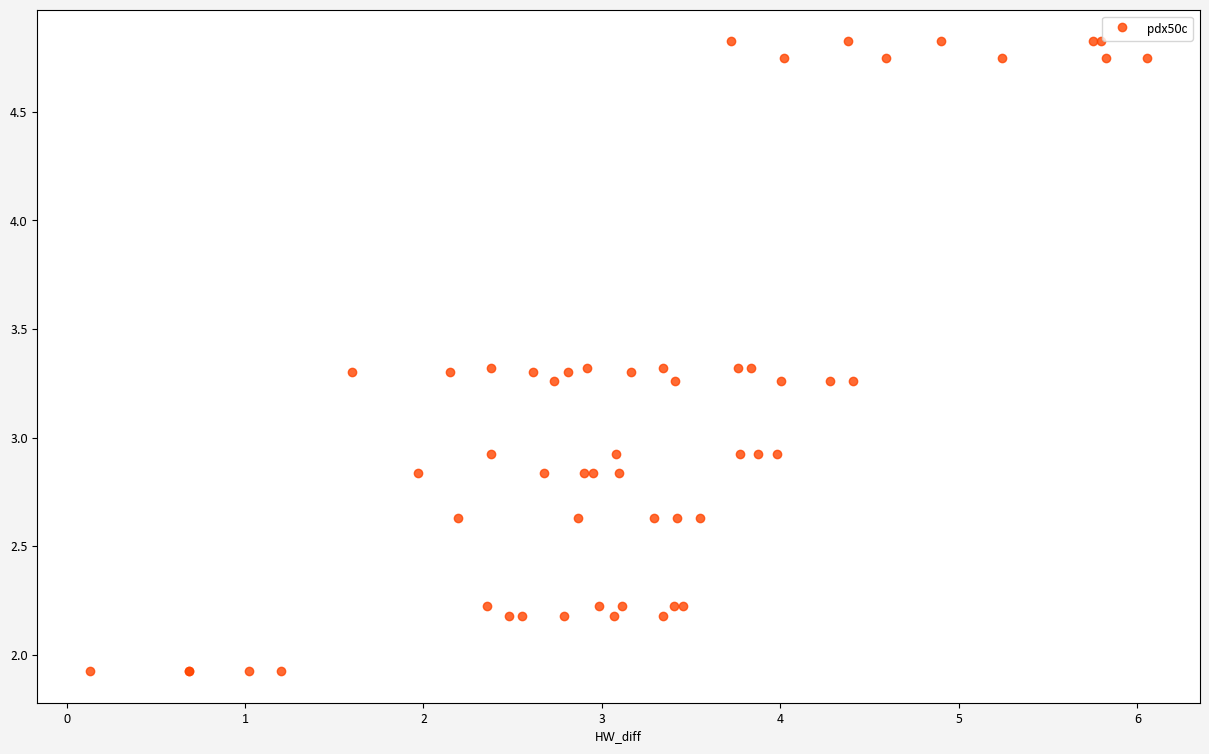

In [58]:
sns.set_style()
plt.rcParams["font.family"] = "Calibri"
f, (ax1) = plt.subplots(figsize=(15,9), facecolor='#f3f3f3d9')

HWd_df_sliced5.plot(x='HW_diff', y='pdx50c', ax=ax1, marker='o', color='orangered', linestyle='none', alpha=.8)

In [67]:
dis_df['pdx50c'] = ap50c.predict(dis_df)
dis_df

,Unnamed: 0,Name_Bezir,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Dist_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,pdx50,pdx50c
0,0,110 Stadtzentrum,7370.186849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24185.537025,0.000000,23495.041093,112451.093688,2.998551e+05,35.800507,45.670071,39.336338,41.295170,35.082062,30.561342,39.846935,35.314964,36.704945,29.028418,167501.858655,0.558609,39.436829,34.291321,1.150053,5.145509,0.024579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080657,0.000000,0.078355,0.375018,4.344597,4.747591
1,1,120 Rheintor/Grafenstraße,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,231176.416702,3.983595e+05,35.462467,45.641220,39.039982,41.081863,34.778698,30.561342,39.846935,35.314964,36.704945,29.028418,231176.416702,0.580321,39.200846,34.291321,1.143171,4.909525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580321,4.518613,4.824443
2,2,130 Hochschulviertel,113671.235126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30495.437374,0.000000,0.000000,0.000000,4.144146e+05,33.821999,43.415585,38.105221,40.093166,32.837387,30.561342,39.846935,35.314964,36.704945,29.028418,144166.672501,0.347880,37.654671,34.291321,1.098082,3.363351,0.274294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073587,0.000000,0.000000,0.000000,0.601467,1.953051
3,3,140 Kapellplatzviertel,1.259645,0.000000,0.000000,11748.238663,33491.589152,9814.215928,51467.207186,0.000000,170223.321769,1391.841472,7752.731375,1467.726794,4.963466e+05,34.337162,43.720726,37.693356,39.781208,33.010876,30.561342,39.846935,35.314964,36.704945,29.028418,287358.131983,0.578946,37.708665,34.291321,1.099656,3.417345,0.000003,0.000000,0.000000,0.023669,0.067476,0.019773,0.103692,0.000000,0.342953,0.002804,0.015620,0.002957,2.562936,2.924770
4,4,150 St. Ludwig mit Eichbergviertel,0.000000,0.000000,0.000000,37064.281641,20746.521595,21350.298699,187793.734718,0.000000,187282.062266,22669.619786,0.000000,0.000000,7.190664e+05,33.851768,43.267216,37.510578,39.568790,32.575256,30.561342,39.846935,35.314964,36.704945,29.028418,476906.518704,0.663230,37.354722,34.291321,1.089335,3.063401,0.000000,0.000000,0.000000,0.051545,0.028852,0.029692,0.261163,0.000000,0.260452,0.031526,0.000000,0.000000,2.510255,2.630828
5,5,210 Johannesviertel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3016.728953,256857.942212,0.000000,0.000000,0.000000,3.825322e+05,34.566647,44.125946,38.049030,40.116562,33.433140,30.561342,39.846935,35.314964,36.704945,29.028418,259874.671166,0.679354,38.058265,34.291321,1.109851,3.766944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007886,0.671467,0.000000,0.000000,0.000000,3.249515,3.261119
6,6,220 Martinsviertel-West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,262526.016015,0.000000,0.000000,0.000000,3.790551e+05,33.901546,43.611950,37.695557,39.622620,32.864468,30.561342,39.846935,35.314964,36.704945,29.028418,262526.016015,0.692580,37.539228,34.291321,1.094715,3.247907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692580,0.000000,0.000000,0.000000,3.343987,3.320160
7,7,230 Martinsviertel-Ost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,197569.423662,0.000000,0.000000,0.000000,2.905144e+05,33.173836,42.659412,36.916275,38.852608,32.190651,30.561342,39.846935,35.314964,36.704945,29.028418,197569.423662,0.680068,36.758556,34.291321,1.071949,2.467236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680068,0.000000,0.000000,0.000000,3.283573,3.301224
8,8,240 Waldkolonie,0.000000,0.000000,

<Axes: xlabel='HW_diff'>

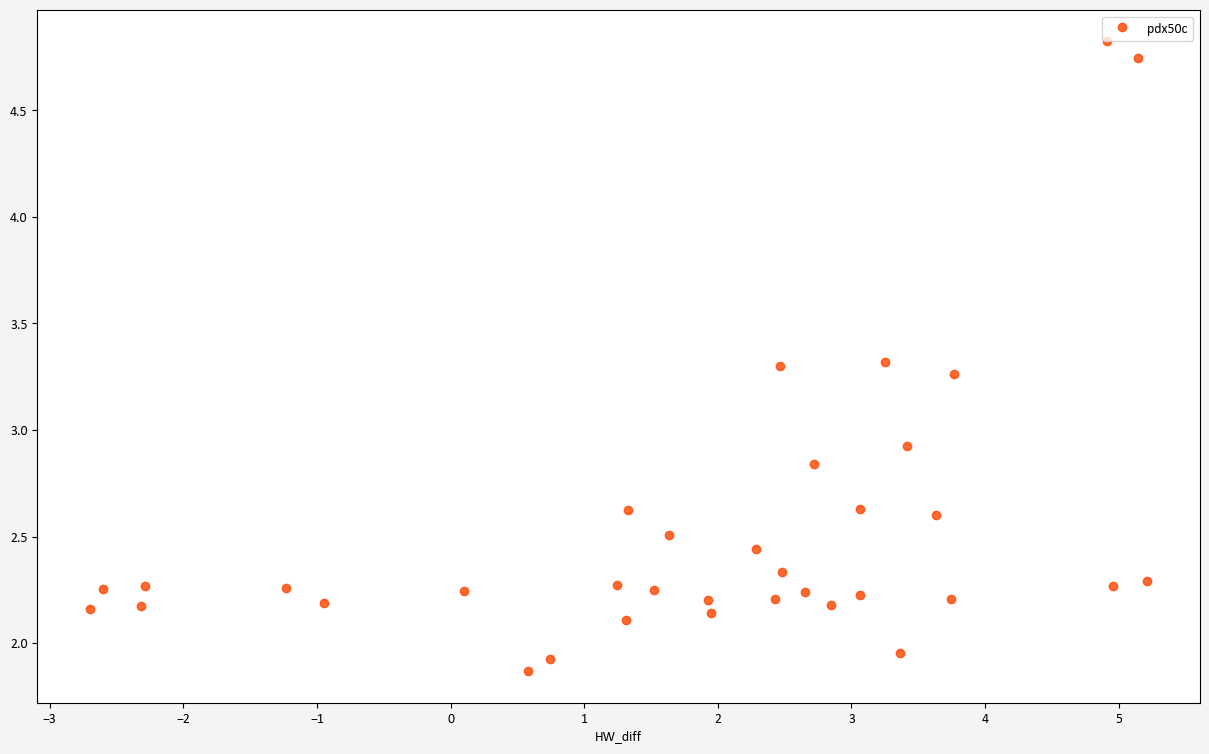

In [68]:
sns.set_style()
plt.rcParams["font.family"] = "Calibri"
f, (ax1) = plt.subplots(figsize=(15,9), facecolor='#f3f3f3d9')

dis_df.plot(x='HW_diff', y='pdx50c', ax=ax1, marker='o', color='orangered', linestyle='none', alpha=.8)

In [69]:
dis_df_sliced5 = dis_df.drop(dis_df[dis_df['Ar_ratio'] < 0.5].index)
dis_df_sliced5

,Unnamed: 0,Name_Bezir,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,Dist_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,pdx50,pdx50c
0,0,110 Stadtzentrum,7370.186849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24185.537025,0.000000,23495.041093,112451.093688,2.998551e+05,35.800507,45.670071,39.336338,41.295170,35.082062,30.561342,39.846935,35.314964,36.704945,29.028418,167501.858655,0.558609,39.436829,34.291321,1.150053,5.145509,0.024579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080657,0.000000,0.078355,0.375018,4.344597,4.747591
1,1,120 Rheintor/Grafenstraße,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,231176.416702,3.983595e+05,35.462467,45.641220,39.039982,41.081863,34.778698,30.561342,39.846935,35.314964,36.704945,29.028418,231176.416702,0.580321,39.200846,34.291321,1.143171,4.909525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.580321,4.518613,4.824443
3,3,140 Kapellplatzviertel,1.259645,0.000000,0.000000,11748.238663,33491.589152,9814.215928,51467.207186,0.000000,170223.321769,1391.841472,7752.731375,1467.726794,4.963466e+05,34.337162,43.720726,37.693356,39.781208,33.010876,30.561342,39.846935,35.314964,36.704945,29.028418,287358.131983,0.578946,37.708665,34.291321,1.099656,3.417345,0.000003,0.000000,0.000000,0.023669,0.067476,0.019773,0.103692,0.000000,0.342953,0.002804,0.015620,0.002957,2.562936,2.924770
4,4,150 St. Ludwig mit Eichbergviertel,0.000000,0.000000,0.000000,37064.281641,20746.521595,21350.298699,187793.734718,0.000000,187282.062266,22669.619786,0.000000,0.000000,7.190664e+05,33.851768,43.267216,37.510578,39.568790,32.575256,30.561342,39.846935,35.314964,36.704945,29.028418,476906.518704,0.663230,37.354722,34.291321,1.089335,3.063401,0.000000,0.000000,0.000000,0.051545,0.028852,0.029692,0.261163,0.000000,0.260452,0.031526,0.000000,0.000000,2.510255,2.630828
5,5,210 Johannesviertel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3016.728953,256857.942212,0.000000,0.000000,0.000000,3.825322e+05,34.566647,44.125946,38.049030,40.116562,33.433140,30.561342,39.846935,35.314964,36.704945,29.028418,259874.671166,0.679354,38.058265,34.291321,1.109851,3.766944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007886,0.671467,0.000000,0.000000,0.000000,3.249515,3.261119
6,6,220 Martinsviertel-West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,262526.016015,0.000000,0.000000,0.000000,3.790551e+05,33.901546,43.611950,37.695557,39.622620,32.864468,30.561342,39.846935,35.314964,36.704945,29.028418,262526.016015,0.692580,37.539228,34.291321,1.094715,3.247907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692580,0.000000,0.000000,0.000000,3.343987,3.320160
7,7,230 Martinsviertel-Ost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,197569.423662,0.000000,0.000000,0.000000,2.905144e+05,33.173836,42.659412,36.916275,38.852608,32.190651,30.561342,39.846935,35.314964,36.704945,29.028418,197569.423662,0.680068,36.758556,34.291321,1.071949,2.467236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.680068,0.000000,0.000000,0.000000,3.283573,3.301224
16,16,410 Paulusviertel,17937.961906,14170.000051,0.000000,590539.565281,2099.270686,78867.479755,43453.896779,0.000000,83382.294698,6944.579674,0.000000,0.000000,1.370121e+06,31.765291,40.531292,35.446640,37.389824,30.049833,30.561342,39.846935,35.314964,36.704945,29.028418,837395.048830,0.611183,35.036576,34.291321,1.021733,0.745255,0.013092,0.010342,0.000000,0.431013,0.001532,0.057562,0.031715,0.000000,0.060858,0.005069,0.000000,0.000000,1.540590,1.924486
17,17,420 Alt-Bes

In [79]:
test = temp_df.copy()
test

,Unnamed: 0,hex_id,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,geometry,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio
0,0,8963926d967ffff,0.000000,0.000000,0.000000,5.998332e+03,70.591067,6825.110809,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,POLYGON ((477290.49281382794 5526006.947530797...,5.368120e+04,29.838594,38.552288,33.805782,35.329655,28.363529,30.561342,39.846935,35.314964,36.704945,29.028418,1.289403e+04,0.240196,33.177970,34.291321,0.967533,-1.113351,0.000000,0.000000,0.000000,0.111740,0.001315,0.127142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,8963926d96bffff,0.000000,0.000000,0.000000,4.862789e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((477149.6112170265 5525546.056756636,...",5.369241e+04,30.090197,40.005802,38.112843,40.148472,30.232922,30.561342,39.846935,35.314964,36.704945,29.028418,4.862789e+01,0.000906,35.718047,34.291321,1.041606,1.426726,0.000000,0.000000,0.000000,0.000906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,8963926d96fffff,0.000000,0.000000,0.000000,1.180638e+04,7838.689081,11650.211475,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((477129.1622616062 5525860.205892096,...",5.368647e+04,31.541504,40.954422,36.515518,38.647854,30.852018,30.561342,39.846935,35.314964,36.704945,29.028418,3.129528e+04,0.582927,35.702263,34.291321,1.041146,1.410942,0.000000,0.000000,0.000000,0.219914,0.146009,0.217005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,8963926da2bffff,0.000000,0.000000,334.173365,4.867466e+03,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((476465.0194345184 5522926.877499968,...",5.375440e+04,32.791145,40.753078,35.644665,37.387890,29.111219,30.561342,39.846935,35.314964,36.704945,29.028418,5.201639e+03,0.096767,35.137600,34.291321,1.024679,0.846279,0.000000,0.000000,0.006217,0.090550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,8963926da2fffff,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,5.182625e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((476444.6182296016 5523241.140425796,...",5.374846e+04,30.724434,38.766953,33.711040,35.695545,28.776838,30.561342,39.846935,35.314964,36.704945,29.028418,5.182625e+03,0.096424,33.534962,34.291321,0.977943,-0.756359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096424,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,8663926dfffffff,922.802293,50699.605012,35071.489564,6.199572e+05,39433.028030,65086.762080,7.795645e+04,12968.175348,5.878773e+04,627.097848,0.000000,0.000000,"POLYGON ((476301.8604579906 5525440.669044014,...",1.842759e+07,29.327410,37.344666,33.491508,34.755138,27.551323,30.561342,39.846935,35.314964,36.704945,29.028418,9.615103e+05,0.052178,32.494009,34.291321,0.947587,-1.797312,0.000050,0.002751,0.001903,0.033643,0.002140,0.003532,0.004230,0.000704,0.003190,0.000034,0.000000,0.000000
720,1,867a9328fffffff,267940.237753,98431.234978,211485.325680,1.178889e+06,187608.050612,337257.313423,1.261975e+06,52839.505825,1.569654e+06,294554.184609,31247.772468,345095.237183,POLYGON ((472626.5278620549 5526759.1689504245...,1.843705e+07,33.737103,43.723404,38.011215,40.049339,32.837048,30.561342,39.846935,35.314964,36.704945,29.028418,5.836977e+06,0.316589,37.671622,34.291321,1.098576,3.380301,0.014533,0.005339,0.011471,0.063941,0.010176,0.018292,0.068448,0.002866,0.085136,0.015976,0.001695,0.018717
721,2,867a9329fffffff,19996.898504,0.000000,308957.288471,9.74

In [88]:
test['pdx50c'] = p50c.predict(test)
test['pdx50'] = p50.predict(test)
test['pdx100'] = p100.predict(test)
test['pdx20'] = p20.predict(test)
test['pdx100c'] = p100c.predict(test)
test

,Unnamed: 0,hex_id,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,geometry,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,pdx50c,pdx50,pdx100,pdx20,pdx100c
0,0,8963926d967ffff,0.000000,0.000000,0.000000,5.998332e+03,70.591067,6825.110809,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,POLYGON ((477290.49281382794 5526006.947530797...,5.368120e+04,29.838594,38.552288,33.805782,35.329655,28.363529,30.561342,39.846935,35.314964,36.704945,29.028418,1.289403e+04,0.240196,33.177970,34.291321,0.967533,-1.113351,0.000000,0.000000,0.000000,0.111740,0.001315,0.127142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.364627,0.881964,0.930245,0.895833,1.780236
1,1,8963926d96bffff,0.000000,0.000000,0.000000,4.862789e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((477149.6112170265 5525546.056756636,...",5.369241e+04,30.090197,40.005802,38.112843,40.148472,30.232922,30.561342,39.846935,35.314964,36.704945,29.028418,4.862789e+01,0.000906,35.718047,34.291321,1.041606,1.426726,0.000000,0.000000,0.000000,0.000906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.271054,0.001731,0.001806,0.001731,1.582855
2,2,8963926d96fffff,0.000000,0.000000,0.000000,1.180638e+04,7838.689081,11650.211475,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((477129.1622616062 5525860.205892096,...",5.368647e+04,31.541504,40.954422,36.515518,38.647854,30.852018,30.561342,39.846935,35.314964,36.704945,29.028418,3.129528e+04,0.582927,35.702263,34.291321,1.041146,1.410942,0.000000,0.000000,0.000000,0.219914,0.146009,0.217005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.393820,2.044500,2.546804,2.278936,2.342741
3,3,8963926da2bffff,0.000000,0.000000,334.173365,4.867466e+03,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((476465.0194345184 5522926.877499968,...",5.375440e+04,32.791145,40.753078,35.644665,37.387890,29.111219,30.561342,39.846935,35.314964,36.704945,29.028418,5.201639e+03,0.096767,35.137600,34.291321,1.024679,0.846279,0.000000,0.000000,0.006217,0.090550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.170716,0.192146,0.202978,0.193743,1.543096
4,4,8963926da2fffff,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,5.182625e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,"POLYGON ((476444.6182296016 5523241.140425796,...",5.374846e+04,30.724434,38.766953,33.711040,35.695545,28.776838,30.561342,39.846935,35.314964,36.704945,29.028418,5.182625e+03,0.096424,33.534962,34.291321,0.977943,-0.756359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096424,0.000000,0.000000,0.000000,0.000000,0.000000,2.235533,0.271398,0.384819,0.370835,1.677302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0,8663926dfffffff,922.802293,50699.605012,35071.489564,6.199572e+05,39433.028030,65086.762080,7.795645e+04,12968.175348,5.878773e+04,627.097848,0.000000,0.000000,"POLYGON ((476301.8604579906 5525440.669044014,...",1.842759e+07,29.327410,37.344666,33.491508,34.755138,27.551323,30.561342,39.846935,35.314964,36.704945,29.028418,9.615103e+05,0.052178,32.494009,34.291321,0.947587,-1.797312,0.000050,0.002751,0.001903,0.033643,0.002140,0.003532,0.004230,0.000704,0.003190,0.000034,0.000000,0.000000,2.231307,0.121128,0.138510,0.130905,1.585265
720,1,867a9328fffffff,267940.237753,98431.234978,211485.325680,1.178889e+06,187608.050612,337257.313423,1.261975e+06,52839.505825,1.569654e+06,294554.184609,31247.772468,345095.237183,POLYGON ((472626.5278620549 5526759.1689504245...,1.843705e+07,33.737

<Axes: xlabel='HW_diff'>

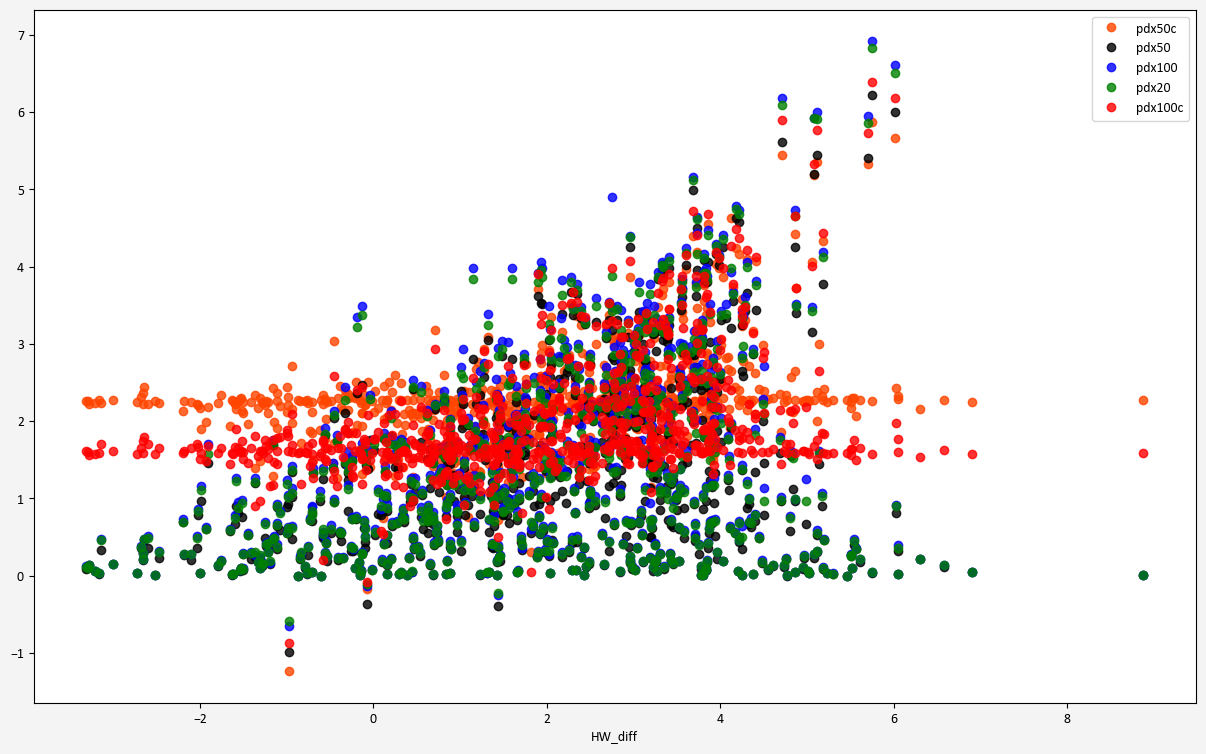

In [94]:
sns.set_style()
plt.rcParams["font.family"] = "Calibri"
f, (ax1) = plt.subplots(figsize=(15,9), facecolor='#f3f3f3d9')

test.plot(x='HW_diff', y='pdx50c', ax=ax1, marker='o', color='orangered', linestyle='none', alpha=.8)
test.plot(x='HW_diff', y='pdx50', ax=ax1, marker='o', color='k', linestyle='none', alpha=.8)
test.plot(x='HW_diff', y='pdx100', ax=ax1, marker='o', color='b', linestyle='none', alpha=.8)
test.plot(x='HW_diff', y='pdx20', ax=ax1, marker='o', color='g', linestyle='none', alpha=.8)
test.plot(x='HW_diff', y='pdx100c', ax=ax1, marker='o', color='r', linestyle='none', alpha=.8)

In [90]:
test50 = test.drop(test[test['Ar_ratio'] < 0.5].index)
test50

,Unnamed: 0,hex_id,EST11,EST12,EST13,EST1A,EST1B,EST2,EST3,EST4,EST5,EST6,EST7,EST8,geometry,hex_area,HW_1,HW_2,HW_3,HW_4,HW_5,HW1_city,HW2_city,HW3_city,HW4_city,HW5_city,Typ_tot_ar,Ar_ratio,HW_avg,HW_city_avg,HW_ratio,HW_diff,EST11_ratio,EST12_ratio,EST13_ratio,EST1A_ratio,EST1B_ratio,EST2_ratio,EST3_ratio,EST4_ratio,EST5_ratio,EST6_ratio,EST7_ratio,EST8_ratio,pdx50c,pdx50,pdx100,pdx20,pdx100c
2,2,8963926d96fffff,0.000000,0.000000,0.000000,11806.381376,7838.689081,11650.211475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((477129.1622616062 5525860.205892096,...",5.368647e+04,31.541504,40.954422,36.515518,38.647854,30.852018,30.561342,39.846935,35.314964,36.704945,29.028418,3.129528e+04,0.582927,35.702263,34.291321,1.041146,1.410942,0.000000,0.000000,0.000000,0.219914,0.146009,0.217005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.393820,2.044500,2.546804,2.278936,2.342741
10,10,8963926db07ffff,0.000000,0.000000,0.000000,10737.055166,0.000000,6917.280061,11030.573856,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((476685.8958030727 5524791.609765469,...",5.371416e+04,31.404812,40.771397,35.854816,37.769802,30.042322,30.561342,39.846935,35.314964,36.704945,29.028418,2.868491e+04,0.534029,35.168630,34.291321,1.025584,0.877309,0.000000,0.000000,0.000000,0.199892,0.000000,0.128779,0.205357,0.000000,0.000000,0.000000,0.000000,0.000000,2.191610,1.632602,1.926314,1.856449,1.939126
11,11,8963926db0bffff,0.000000,0.000000,0.000000,37745.307488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,POLYGON ((476544.87802866095 5524330.636730341...,5.372537e+04,32.366734,41.454296,36.277149,38.295326,30.972017,30.561342,39.846935,35.314964,36.704945,29.028418,3.774531e+04,0.702560,35.873104,34.291321,1.046128,1.581784,0.000000,0.000000,0.000000,0.702560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.490623,1.342917,1.400604,1.342738,1.260310
13,13,8963926db1bffff,0.000000,0.000000,0.000000,23281.944413,0.000000,0.000000,0.000000,8135.279331,0.000000,0.000000,0.000000,0.000000,"POLYGON ((476726.7324419949 5524163.199440571,...",5.372604e+04,31.341291,40.314175,35.095062,37.192204,29.778555,30.561342,39.846935,35.314964,36.704945,29.028418,3.141722e+04,0.584767,34.744257,34.291321,1.013208,0.452937,0.000000,0.000000,0.000000,0.433346,0.000000,0.000000,0.000000,0.151422,0.000000,0.000000,0.000000,0.000000,1.269912,0.971692,1.020736,1.008033,0.976495
14,14,8963926db23ffff,0.000000,0.000000,0.000000,41823.418947,0.000000,1536.476479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((476483.6663847779 5525273.230262783,...",5.370756e+04,31.671564,40.754150,35.659184,37.540199,30.479263,30.561342,39.846935,35.314964,36.704945,29.028418,4.335990e+04,0.807333,35.220872,34.291321,1.027107,0.929551,0.000000,0.000000,0.000000,0.778725,0.000000,0.028608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.454709,1.637900,1.709781,1.640396,1.280276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,101,887a932d5dfffff,0.000000,0.000000,0.000000,80946.677696,448.980802,9896.262089,8504.597330,0.000000,0.000000,175325.229915,0.000000,0.000000,"POLYGON ((474323.6619515337 5518984.816056862,...",3.770524e+05,34.134586,43.632587,37.931843,40.118874,32.631901,30.561342,39.846935,35.314964,36.704945,29.028418,2.751217e+05,0.729664,37.689958,34.291321,1.099111,3.398637,0.000000,0.000000,0.000000,0.214683,0.001191,0.026246,0.022555,0.000000,0.000000,0.464989,0.000000,0.000000,3.116558,3.078705,3.214662,3.168852,3.108065
685,108,887a932f25fffff,0.000000,0.000000,34796.197737,105461.869276,0.000000,32366.364704,19376.998012,5348.566495,0.000000,7624.614665,0.000000,0.000000,"POLYGON ((473433.9440108918 5522170.533838148,...",3.767008e+05,33.180996,43.276115,37.996590,40.128819,31.521799,30.561342,39.846935,35.31496

<Axes: xlabel='HW_diff'>

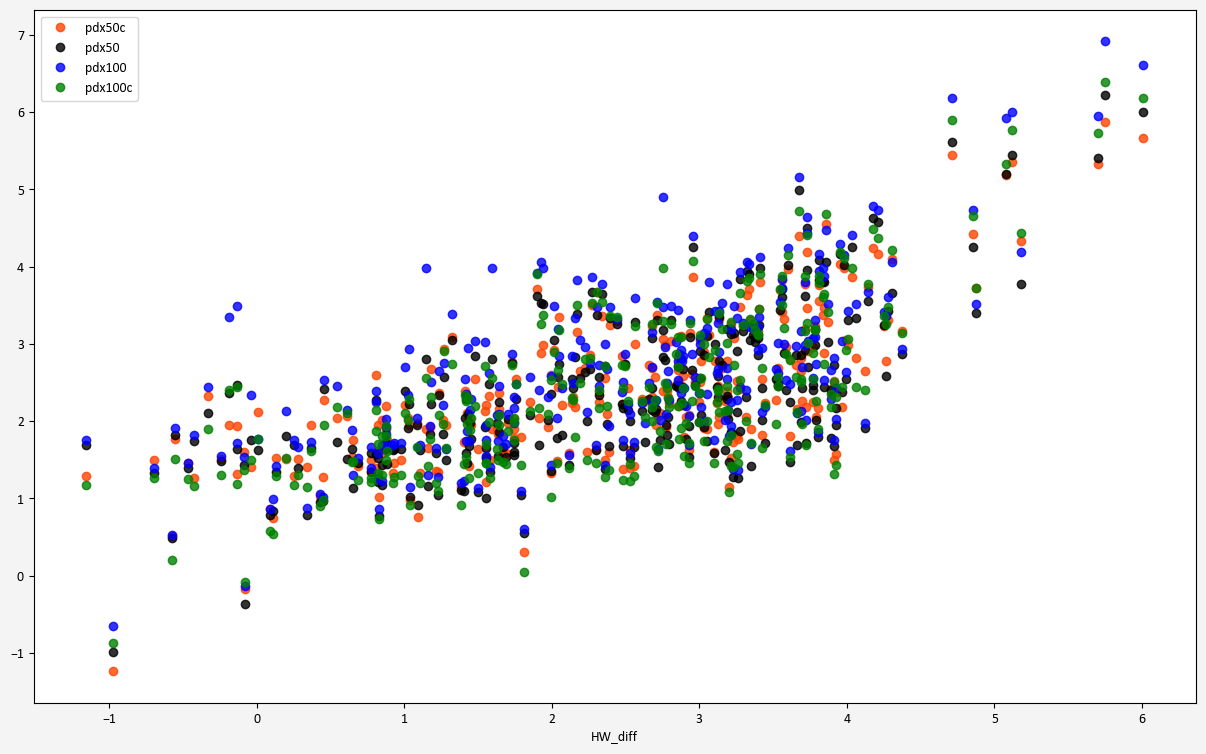

In [92]:
sns.set_style()
plt.rcParams["font.family"] = "Calibri"
f, (ax1) = plt.subplots(figsize=(15,9), facecolor='#f3f3f3d9')

test50.plot(x='HW_diff', y='pdx50c', ax=ax1, marker='o', color='orangered', linestyle='none', alpha=.8)
test50.plot(x='HW_diff', y='pdx50', ax=ax1, marker='o', color='k', linestyle='none', alpha=.8)
test50.plot(x='HW_diff', y='pdx100', ax=ax1, marker='o', color='b', linestyle='none', alpha=.8)
test50.plot(x='HW_diff', y='pdx100c', ax=ax1, marker='o', color='g', linestyle='none', alpha=.8)